# Neighborhood analysis 

In [1]:
import pickle
import sys, os
sys.path.append("/Users/chilpert/Dev/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Dev/pyproteins/src")
import pyproteinsExt 
import pyproteins
import time
import subprocess
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pyproteinsExt.uniprot as uniprot
import pyproteinsExt.ena as ena
import seaborn as sns
from collections import OrderedDict
from igraph import Graph, plot

In [2]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    print(saveDir + "/" + fileName)
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

### Load data

In [51]:
data=load("NOX_annotation_validatedProteins_20190808-155906.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_validatedProteins_20190808-155906.pickle
restore a annotated container of  769 elements


### Get uniprot entries

In [52]:
uColl=uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot")
c = 1
for e in data:
    if c % 10 == 0: 
        print(c,"/",len(data))
    e.set_uniprot_xref(uColl)
    c += 1
#uColl.serialize(ext=".xml")

Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/uniprot
Reindexing /Users/chilpert/cache/uniprot
Acknowledged 869 entries (/Users/chilpert/cache/uniprot)
10 / 769
20 / 769
30 / 769
40 / 769
50 / 769
60 / 769
70 / 769
80 / 769
90 / 769
100 / 769
110 / 769
120 / 769
130 / 769
140 / 769
150 / 769
160 / 769
170 / 769
180 / 769
190 / 769
200 / 769
210 / 769
220 / 769
230 / 769
240 / 769
250 / 769
260 / 769
270 / 769
280 / 769
290 / 769
300 / 769
310 / 769
320 / 769
330 / 769
340 / 769
350 / 769
360 / 769
370 / 769
380 / 769
390 / 769
400 / 769
410 / 769
420 / 769
430 / 769
440 / 769
450 / 769
460 / 769
470 / 769
480 / 769
490 / 769
500 / 769
510 / 769
520 / 769
530 / 769
540 / 769
550 / 769
560 / 769
570 / 769
580 / 769
590 / 769
600 / 769
610 / 769
620 / 769
630 / 769
640 / 769
650 / 769
660 / 769
670 / 769
680 / 769
690 / 769
700 / 769
710 / 769
720 / 769
730 / 769
740 / 769
750 / 769
760 / 769


### Filter proteins with no uniprot entry

In [53]:
def filter_no_uniprot(entry): 
    if entry.uniprot_xref:
        return True 
    return False

In [54]:
data_uniprot=data.filter(filter_no_uniprot)
print(len(data_uniprot),"proteins with uniprot entry.")

694 proteins with uniprot entry.


In [7]:
save(data_uniprot, "withUniprotEntry")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_withUniprotEntry_20190808-165157.pickle


#### Write embl ids in file

In [13]:
o1 = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt","w")
o2 = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt","w")

for e in data_uniprot:
    genome = list(e.uniprot_xref["EMBL"].keys())[0]
    if len(genome)==8:
        o1.write(genome + "\n")
    else: 
        o2.write(genome + "\n")
        
o1.close()
o2.close()

146 proteins with EMBL assembly (Sequence). 548 proteins with EMBL assembly contigs (WGS)

### Download embl files in cache 
```console
    python /Users/chilpert/Dev/NOX/download_ena_url.py /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt /Users/chilpert/cache/ena
    cd /Users/chilpert/cache/ena
    bash /Users/chilpert/Dev/NOX/download_ena_wgs_ftp.sh /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt
```

#### Rename .dat.gz files 
```console 
for f in $(ls *.dat.gz); do 
    name=$(echo $f | cut -f 1 -d ".");
    mv $f $name.embl.gz;
done 
```

#### Check if all genomes have been downloaded

```console 
cd /Users/chilpert/cache/ena

ls *.embl | cut -f 1 -d "." > list_embl.txt
python /Users/chilpert/Dev/NOX/compare_two_lists.py /Users/chilpert/cache/ena/list_embl.txt /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt > sequence_diff.txt
for id in $(cat sequence_diff.txt);  do if [[ ! -f $id.embl ]]; then echo $id; fi ; done

ls *.embl.gz | cut -f 1 -d "." > list_gz.txt
for id in $(cat /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt); do 
    echo $(echo $id | head -c 6)
done > /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_short_id_wgs.txt
python /Users/chilpert/Dev/NOX/compare_two_lists.py /Users/chilpert/cache/ena/list_gz.txt /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_short_id_wgs.txt > wgs_diff.txt
for id in $(cat wgs_diff.txt);  do if [[ ! -f $id.embl.gz ]]; then echo $id; fi ; done
```

All genome Sequence have been downloaded. One genome WGS not downloaded : AAACMK010000006.

#### Check files size
```console
du -sh * | grep "0B" 
```

All files contains something

* Check AAACMK010000006

In [55]:
for e in data_uniprot: 
    if "AAACMK010000006" in e.uniprot_xref["EMBL"]:
        print(e.uniprot_xref)

{'EMBL': {'AAACMK010000006': 'EAA7628312.1', 'AAACPN010000018': 'EAA7907854.1', 'AAACPY010000009': 'EAA8025228.1', 'AAACVM010000005': 'EAA8693673.1', 'AAACXE010000007': 'EAA8814595.1', 'QDUO01000004': 'PVT80048.1'}, 'RefSeq': {'NZ_QDUO01000004.1': 'WP_023893330.1'}}


Download manually QDUO01000004 instead of AAACMK010000006 and modify uniprot_xref
```console
cd /Users/chilpert/cache/ena
wget http://ftp.ebi.ac.uk/pub/databases/ena/wgs/public/qd/QDUO01.dat.gz
```

In [56]:
data_uniprot.entries["tr|A0A2T9QBC4|A0A2T9QBC4_SALET"].uniprot_xref = {'EMBL': {'QDUO01000004': 'PVT80048.1', 'AAACMK010000006': 'EAA7628312.1', 'AAACPN010000018': 'EAA7907854.1', 'AAACPY010000009': 'EAA8025228.1', 'AAACVM010000005': 'EAA8693673.1', 'AAACXE010000007': 'EAA8814595.1'}, 'RefSeq': {'NZ_QDUO01000004.1': 'WP_023893330.1'}}
save(data_uniprot, "allUniprotEntry")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_allUniprotEntry_20190828-170247.pickle


### Read and store embl information
EMBL genomes have to be in cache

In [6]:
data_uniprot = load("NOX_annotation_allUniprotEntry_20190828-170247.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_allUniprotEntry_20190828-170247.pickle
restore a annotated container of  694 elements


In [7]:
enaColl=ena.getENACollection()
enaColl.setCache("/Users/chilpert/cache/ena")

Get ENA Collection
Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/ena
Reindexing /Users/chilpert/cache/ena
Acknowledged 810 entries (/Users/chilpert/cache/ena)


In [8]:
c = 1
for e in data_uniprot:
    if c % 10 == 0:
        print("==", c,"/",len(data_uniprot))
    c+=1    
    e.set_all_genome_features(enaColl)
    e.set_neighborhood(10,enaColl)
    e.delete_all_genome_features()

== 10 / 694
== 20 / 694
== 30 / 694
== 40 / 694
== 50 / 694
== 60 / 694
== 70 / 694
== 80 / 694
== 90 / 694
== 100 / 694
== 110 / 694
== 120 / 694
== 130 / 694
== 140 / 694
== 150 / 694
== 160 / 694
== 170 / 694
== 180 / 694
== 190 / 694
== 200 / 694
== 210 / 694
== 220 / 694
== 230 / 694
== 240 / 694
== 250 / 694
== 260 / 694
== 270 / 694
== 280 / 694
== 290 / 694
== 300 / 694
== 310 / 694
== 320 / 694
== 330 / 694
== 340 / 694
== 350 / 694
== 360 / 694
== 370 / 694
== 380 / 694
== 390 / 694
== 400 / 694
== 410 / 694
== 420 / 694
== 430 / 694
== 440 / 694
== 450 / 694
== 460 / 694
== 470 / 694
== 480 / 694
== 490 / 694
== 500 / 694
== 510 / 694
== 520 / 694
== 530 / 694
== 540 / 694
== 550 / 694
== 560 / 694
== 570 / 694
== 580 / 694
== 590 / 694
== 600 / 694
== 610 / 694
== 620 / 694
== 630 / 694
== 640 / 694
== 650 / 694
== 660 / 694
== 670 / 694
== 680 / 694
== 690 / 694


#### Filter protein with no neighborhood

In [51]:
def filter_no_neighborhood(entry):
    if len(entry.neighborhood_ena_entry.features) == 0:
        return False
    return True

In [54]:
data_uniprot = data_uniprot.filter(filter_no_neighborhood)
print(len(data_uniprot), "proteins with neighborhood")

691 proteins with neighborhood


In [55]:
save(data_uniprot, "neighborhood10")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle


### Serialize neighbors protein sequences

In [56]:
data_uniprot = load("NOX_annotation_neighborhood10_20190829-111835.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle
restore a annotated container of  691 elements


In [57]:
all_neighbors = 0
for e in data_uniprot:
    all_neighbors += len(e.neighborhood_ena_entry.features)
    if len(e.neighborhood_ena_entry.features) > 20:
        print(e.prot)
        print(len(e.neighborhood_ena_entry.features))

print(all_neighbors, "neighborhood proteins")

12446 neighborhood proteins


In [58]:
with open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins.fasta","w") as o:
    for e in data_uniprot:
        o.write(e.neighbors_sequences_fasta)

### Cluster neighborhood proteins
With mmseqs2, default threshold 80%

```console 
WORKDIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood

mkdir -p $WORKDIR/clustering

mmseqs createdb $WORKDIR/neighbors_proteins.fasta $WORKDIR/clustering/neighbors_proteins.mmseqsdb

mmseqs cluster $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/clustering/tmp_neighbors_proteins_cluster

mmseqs createtsv $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/neighbors_proteins_cluster.tsv --full-header
```



### Parse clustering result

In [13]:
from collections import OrderedDict
dic_cluster = {}
cluster_nb = 0
browse_representative = set()
f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv", "r")
for l in f:
    l_split = l.rstrip().split("\t")
    representative = l_split[0].split(" ")[0].strip('"')
    seq = l_split[1].split(" ")[0].strip('"')
    product = " ".join(l_split[1].split(" ")[1:]).strip('"').rstrip()
    if representative not in browse_representative:
        cluster_nb += 1
        browse_representative.add(representative)
    if cluster_nb not in dic_cluster:
        dic_cluster[cluster_nb] = {'details':{}}
    dic_cluster[cluster_nb]['details'][seq]={'product':product}   
f.close()

print(len(dic_cluster), "clusters created.")

dic_cluster = OrderedDict(sorted(dic_cluster.items(),
                                     key=lambda kv: len(kv[1]["details"]),
                                     reverse=True))

5103 clusters created.


### Check cluster type
Cluster can be : 
* singleton : only one protein in cluster
* only in same neighborhood : proteins of cluster belong to same genome (kind of duplication)
* only in different neighborhood : proteins of clusters appear only 1 time in different genomes
* both : proteins of cluster appar 1 or more time in different genomes

In [15]:
for c in dic_cluster: 
    if len(dic_cluster[c]['details']) == 1:
        dic_cluster[c]["type"] = "singleton"
    else: 
        nb_prot = len(dic_cluster[c]["details"])
        nox = set([p.split("+")[0] for p in dic_cluster[c]["details"]])
        if len(nox) == 1:
            dic_cluster[c]["type"] = "only_in_same_neighborhood"
        elif len(nox) == nb_prot : 
            dic_cluster[c]["type"] = "only_in_different_neighborhood"
        else: 
            dic_cluster[c]["type"] = "both"

### Represent clusters characteristics

#### Distribution of clusters size

159 maximum cluster size


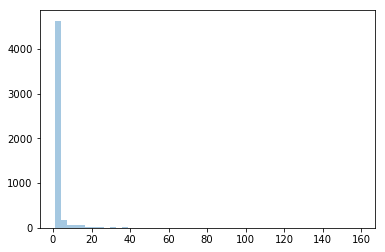

In [18]:
clusters_size = [len(dic_cluster[c]["details"]) for c in dic_cluster]
sns.distplot(clusters_size, kde=False)
print(max(clusters_size), "maximum cluster size")

#### Cluster types

Singletons : 3554
Only in same neighborhood : 30
Only in different neighborhood : 1452
In different neighborhood, at least two times in one of them : 67


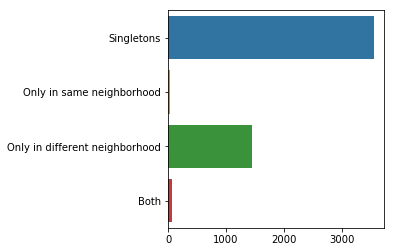

In [19]:
nb_singleton = len([c for c in dic_cluster if dic_cluster[c]["type"] == "singleton"]) 
nb_same_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"]=="only_in_same_neighborhood"]) 
nb_unique_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"] == "only_in_different_neighborhood"]) 
nb_both = len([c for c in dic_cluster if dic_cluster[c]["type"] == "both"]) 
y = ["Singletons", "Only in same neighborhood", "Only in different neighborhood", "Both"]
x = [nb_singleton, nb_same_neighborhood, nb_unique_neighborhood, nb_both]
plot = sns.barplot(x,y)
plt.subplots_adjust(left=0.4)
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/clusters_types.pdf")
print("Singletons :", nb_singleton)
print("Only in same neighborhood :", nb_same_neighborhood)
print("Only in different neighborhood :", nb_unique_neighborhood)
print("In different neighborhood, at least two times in one of them :", nb_both)

#### Neighborhood sizes 
Size of space with 10 proteins before and after NOX

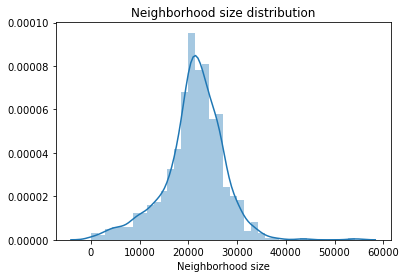

In [20]:
x = []
for e in data_uniprot:
    if len(e.neighborhood_ena_entry.features) != 0: 
        start = e.neighborhood_ena_entry.features[0].location.replace("complement(", '').split("..")[0]
        if "<" in start:
            start = start.replace("<",'')
        end = e.neighborhood_ena_entry.features[-1].location.replace(")", '').split("..")[1]
        if ">" in end:
            end = end.replace(">", '')
        neighborhood_size = int(end) - int(start)
        x.append(neighborhood_size)
plot = sns.distplot(x)   
plot.set(xlabel = "Neighborhood size", title = "Neighborhood size distribution")
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/neighborhood_size_distribution.pdf")

### Add keywords and GO annotation

#### Write neighbors proteins accession id in file

In [21]:
o = open("/Users/chilpert/cache/NOX_neighbors10_protein_id.txt", "w")
for c in dic_cluster:
    for p in dic_cluster[c]["details"]:
        o.write(p.split("+")[2].split(".")[0] + "\n")
o.close()    

#### Download uniprot entry for neighbors
```console
mkdir -p /Users/chilpert/cache/uniprot_neighbors
cd /Users/chilpert/cache/uniprot_neighbors
bash /Users/chilpert/Dev/NOX/download_uniprot_entries_query.sh /Users/chilpert/cache/NOX_neighbors10_protein_id.txt
```

TO DO : Need to separate this in several volume to download quicly.

#### Parse GO and keywords term

In [22]:
uColl = uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot_neighbors")

Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/uniprot_neighbors
Reindexing /Users/chilpert/cache/uniprot_neighbors
Acknowledged 19235 entries (/Users/chilpert/cache/uniprot_neighbors)


#### Add GO, keywords and Interpro information to cluster dictionnary

In [23]:
for c in dic_cluster:
    for p in dic_cluster[c]["details"]: 
        p_id = p.split("+")[2].split(".")[0]
        try : 
            uniprot_entry=uColl.get(p_id, force_reading_cache = True)
        except:
            print(p, "not found")
            dic_cluster[c]["details"][p]["go"] = "uniprot not found"
            dic_cluster[c]["details"][p]["keywords"] = "uniprot not found"
            dic_cluster[c]["details"][p]["interpro"] = "uniprot not found"
            continue
        if not uniprot_entry.GO: 
            go = 'no uniprot go'
        else:    
            go = ";".join(sorted([go.term for go in uniprot_entry.GO]))
        if not uniprot_entry.KW:
            keywords = "no uniprot keywords"
        else:
            keywords = ";".join(sorted([kw.term for kw in uniprot_entry.KW if "proteome" not in kw.term]))
            if not keywords:
                keywords = "proteome"
        if not uniprot_entry.Interpro:
            interpro = "no interpro domains"
        else: 
            interpro = ";".join(sorted([i.id+":"+i.name for i in uniprot_entry.Interpro]))
        dic_cluster[c]["details"][p]["go"] = go
        dic_cluster[c]["details"][p]["keywords"] = keywords
        dic_cluster[c]["details"][p]["interpro"] = interpro

tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS455_Genome_element1+ASZ49468.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS459_Genome_element1+ASZ49471.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS449_Genome_element1+ASZ49462.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS462_Genome_element1+ASZ49474.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS447_Genome_element1+ASZ49460.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS463_Genome_element1+ASZ49475.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS445_Genome_element1+ASZ49458.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS450_Genome_element1+ASZ49463.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS451_Genome_element1+ASZ49464.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS444_Genome_element1+ASZ49457.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS458_Genome_element1+ASZ49470.1 not found


#### Serialize cluster dictionnary

In [24]:
save(dic_cluster,"dic_cluster")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_20190829-104012.pickle


### Define annotation for clusters (at different level) and identify clusters to curate manually. 
Clusters can be annotate at several levels : 
* product : if all proteins of cluster have same product, product annotation is set. 
* uniprot keywords : common keywords among all proteins of cluster is kept for annotation 
* go term : common go term among all proteins of cluster is kept for annotation
* interpro : common interpro domain/family among all proteins of cluster is kept for annotation

A cluster has to be curate manually if no annotation level can be set. 

#### Add clusters information to topology container

In [25]:
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv")

#### Assign taxid and protein list to clusters

In [26]:
for c in dic_cluster:
    prot = [e for e in data_uniprot if c in e.neighborhood_clusters.values()]
    prot_name = [e.prot for e in prot]
    taxids = [e.taxo.taxid for e in prot]
    dic_cluster[c]["taxids"] = taxids
    dic_cluster[c]["nox"] = prot_name

In [27]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
for c in dic_cluster:
    tree = ncbi.get_topology(dic_cluster[c]["taxids"])
    dic_cluster[c]["upper"] = next(tree.traverse())

In [28]:
save(dic_cluster, "dic_cluster_upper_node")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_upper_node_20190829-105240.pickle


#### Annotate clusters

In [9]:
def minimize_annotation(list_annotation):
    '''Conserve only common annotation'''
    list_annotation = [l.split(";") for l in list_annotation]
    for l in list_annotation:
        for word in ["proteome", "no uniprot go", "no uniprot keywords", "no interpro domains", "uniprot not found"]:
            if word in l:
                l.remove(word)
            
    list_annotation = [l for l in list_annotation if l]
    if not list_annotation:
        minim_annotation = "no information"
    elif len(list_annotation) == 1:
        minim_annotation = ";".join(list_annotation[0])
    else:
        minim_annotation = get_similar(list_annotation)
        if not minim_annotation:
            return None
        minim_annotation = ";".join(sorted(list(minim_annotation)))
    return minim_annotation

In [10]:
def get_similar(list_words):
    '''Keep similar words among given lists'''
    words_to_keep = set(list_words[0])
    for i in range(1,len(list_words)):
        words_to_keep = words_to_keep.intersection(set(list_words[i]))
        #print("W",words_to_keep)
        if not words_to_keep: 
            return words_to_keep
    return words_to_keep

In [7]:
dic_cluster = load("NOX_annotation_dic_cluster_upper_node_20190829-105240.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_upper_node_20190829-105240.pickle
restore a annotated container of  5103 elements


In [13]:
kw_annotation_dic = {}
product_annotation_dic = {}
go_annotation_dic = {}
interpro_annotation_dic = {}
for c in dic_cluster : 
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    
    kw_annotation = minimize_annotation(keywords)
    
    go_annotation = minimize_annotation(go)
    
    interpro_annotation = minimize_annotation(interpro)
    
    if kw_annotation:
        kw_annotation_dic[c] = kw_annotation
        
    if go_annotation:
        go_annotation_dic[c] = go_annotation
    
    if interpro_annotation:
        interpro_annotation_dic[c] = interpro_annotation
    
    if "hypothetical protein" in product:
        product.remove("hypothetical protein")
    
    if len(set(product)) == 0:
        product_annotation_dic[c] = "hypothetical protein"
    elif len(set(product)) == 1:
        product_annotation_dic[c] = product[0]

In [160]:
o_name = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_list_annotated_name.txt" , "w")
for c in product_annotation_dic:
    o_name.write(str(c) + "\n")
o_name.close()
o_go = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_list_annotated_go.txt" , "w")
for c in go_annotation_dic:
    o_go.write(str(c) + "\n")
o_go.close()
o_kw = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_list_annotated_kw.txt" , "w")
for c in kw_annotation_dic:
    o_kw.write(str(c) + "\n")
o_kw.close()
o_interpro = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_list_annotated_interpro.txt" , "w")
for c in interpro_annotation_dic:
    o_interpro.write(str(c) + "\n")
o_interpro.close()

In [14]:
product_cluster = set(product_annotation_dic.keys())
go_cluster = set(go_annotation_dic.keys())
kw_cluster = set(kw_annotation_dic.keys())
interpro_cluster = set(interpro_annotation_dic.keys())
print(len(product_cluster), "with product annotation")
print(len(kw_cluster), "with keywords annotation")
print(len(go_cluster), "with go annotation")
print(len(interpro_cluster), "with interpro annotation")

4136 with product annotation
5055 with keywords annotation
5033 with go annotation
5102 with interpro annotation


8 cases : 
    * Just interpro annotation : 20 clusters
    * Keywords and go annotation : 1 cluster
    * Keywords and Interpro annotation : 48 clusters
    * GO and Interpro annotation : 25 clusters
    * Product, Keywords and Interpro annotation : 2 clusters 
    * Product, GO and Interpro annotation : 3 clusters 
    * Keywords, GO and Interpro annotation : 873 clusters
    * All annotations : 4131 clusters (included 3554 singletons)

In [15]:
c_interpro = interpro_cluster.difference(product_cluster).difference(go_cluster).difference(kw_cluster)
print(len(c_interpro))
c_kw_go = kw_cluster.intersection(go_cluster).difference(product_cluster).difference(interpro_cluster)
print(len(c_kw_go))
c_kw_interpro = kw_cluster.intersection(interpro_cluster).difference(product_cluster).difference(go_cluster)
print(len(c_kw_interpro))
c_go_interpro = go_cluster.intersection(interpro_cluster).difference(product_cluster).difference(kw_cluster)
print(len(c_go_interpro))
c_product_kw_interpro = product_cluster.intersection(interpro_cluster).intersection(kw_cluster).difference(go_cluster)
print(len(c_product_kw_interpro))
c_go_product_interpro = go_cluster.intersection(product_cluster).intersection(interpro_cluster).difference(kw_cluster)
print(len(c_go_product_interpro))
c_kw_go_interpro = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).difference(product_cluster)
print(len(c_kw_go_interpro))
c_all = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).intersection(product_cluster)
print(len(c_all))

20
1
48
25
2
3
873
4131


#### Write valid annotated clusters and detailed information on clusters

In [33]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/valid_annotation_clusters.tsv" , "w")
o.write("#Cluster\tNumber of proteins\tNumber of neighborhoods\tUpper node\tProduct\tKeywords\tGO\tInterpro\n")
detail = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/detailed_annotation_clusters.txt", "w")
to_check = set()
for c in dic_cluster: 
    detail.write("#Cluster" + str(c) + "\n")
    for p in dic_cluster[c]["details"]:
        p_id = p.split("+")[2]
        product = dic_cluster[c]["details"][p]["product"] 
        kw = dic_cluster[c]["details"][p]["keywords"] 
        go = dic_cluster[c]["details"][p]["go"] 
        interpro = dic_cluster[c]["details"][p]["interpro"]
        detail.write(p_id + "\t" + product + "\t" + kw + "\t" + go + "\t" + interpro + "\n")
    if c in product_annotation_dic or c in kw_annotation_dic or c in go_annotation_dic or c in interpro_annotation_dic: 
        neighborhood_number = len([e for e in data_uniprot if c in e.neighborhood_clusters.values()])
        upper_node = dic_cluster[c]["upper"].name+":"+dic_cluster[c]["upper"].sci_name
        o.write(str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\t" + str(neighborhood_number) + "\t" + 
                upper_node + "\t" +
                product_annotation_dic.get(c,"-") + "\t" + kw_annotation_dic.get(c,"-") + "\t" +
               go_annotation_dic.get(c,"-") + "\t" + interpro_annotation_dic.get(c,"-") + "\n")
    else: 
        to_check.add(c)
o.close()   
detail.close()

In [34]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/to_check_clusters.txt", "w")
for c in to_check:
    o.write("#Cluster" + str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\n")
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    product = sorted(product, key=lambda e:product.count(e), reverse = True)
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    keywords = sorted(keywords, key=lambda e:keywords.count(e), reverse = True)
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    go = sorted(go, key=lambda e:go.count(e), reverse = True)
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    interpro = sorted(interpro, key=lambda e:interpro.count(e), reverse = True)
    for p in set(product):
        o.write("P\t" + p + "\t" + str(product.count(p)) + "\n")
    for k in set(keywords):
        o.write("KW\t" + k + "\t" + str(keywords.count(k)) + "\n")
    for g in set(go):
        o.write("GO\t" + g + "\t" + str(go.count(g)) + "\n")
    for i in set(interpro):
        o.write("I\t" + i + "\t" + str(interpro.count(i)) + "\n")
o.close()

No cluster to check manually.

### Regroup same annotations
Regroup clusters with same annotation at each level

In [16]:
same_product = {}
same_keywords = {}
same_go = {}
same_interpro = {}
same_all = {}
all_annotation_dic = {}

def add_to_dic(dic,term,cluster):
    if term not in dic:
        dic[term] = []
    dic[term].append(cluster)    

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/valid_annotation_clusters.tsv", "r")
f.readline()
for l in f: 
    l_split = l.rstrip().split("\t")
    cluster = l_split[0] 
    product = l_split[4]
    kw = l_split[5]
    go = l_split[6]
    interpro = l_split[7]
    all = product + "+" + kw + "+" + go + "+" + interpro
    
    all_annotation_dic[int(cluster)] = all
    
    add_to_dic(same_product, product, cluster)
    add_to_dic(same_keywords, kw, cluster)
    add_to_dic(same_go, go, cluster)
    add_to_dic(same_interpro, interpro, cluster)
    add_to_dic(same_all, all, cluster)
    
f.close()
same_product = OrderedDict(sorted(same_product.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_keywords = OrderedDict(sorted(same_keywords.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_go = OrderedDict(sorted(same_go.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_interpro = OrderedDict(sorted(same_interpro.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_all = OrderedDict(sorted(same_all.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))

#### Write outputs

In [36]:
for e in data_uniprot:
    e.clusters_list = list(e.neighborhood_clusters.values())
    e.clusters_annotation = {}
    e.clusters_annotation["product"]=[product_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["keywords"]=[kw_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["go"]=[go_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["interpro"]=[interpro_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["all"]=[all_annotation_dic.get(c,"-") for c in e.clusters_list]

In [37]:
def write_same(file, dic, annotation_type):
    o = open(file,"w")
    o.write("#" + annotation_type + "\t" + "Number of clusters\tNumber of proteins\tNumber of neighborhoods\tUpper node\n")
    count = 0
    print("==",annotation_type)
    for w in dic:
        count += 1
        if count%100 == 0: 
            print(count,"/",len(dic))
        nb_proteins = sum([len(dic_cluster[int(c)]["details"]) for c in dic[w]])
        neighborhoods = set()
        for c in dic[w]:
            neighborhoods.update(dic_cluster[int(c)]["nox"])
        neighborhoods_taxids = [e.taxo.taxid for e in data_uniprot if e.prot in neighborhoods]    
        tree = ncbi.get_topology(neighborhoods_taxids)
        upper_node = next(tree.traverse())
        nb_neighborhoods = len(neighborhoods)
        nb_clusters = len(dic[w])
        o.write(w + "\t" + str(nb_clusters) + "\t" + str(nb_proteins) + "\t" + str(nb_neighborhoods) + "\t" + upper_node.name+":"+upper_node.sci_name + "\n")
    o.close()

write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_product.tsv", same_product, "product")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_keywords.tsv", same_keywords, "Keywords")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_go.tsv", same_go, "GO")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_interpro.tsv", same_interpro, "Interpro")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_all.tsv", same_all, "All annotation")

== product
100 / 1853
200 / 1853
300 / 1853
400 / 1853
500 / 1853
600 / 1853
700 / 1853
800 / 1853
900 / 1853
1000 / 1853
1100 / 1853
1200 / 1853
1300 / 1853
1400 / 1853
1500 / 1853
1600 / 1853
1700 / 1853
1800 / 1853
== Keywords
100 / 679
200 / 679
300 / 679
400 / 679
500 / 679
600 / 679
== GO
100 / 1243
200 / 1243
300 / 1243
400 / 1243
500 / 1243
600 / 1243
700 / 1243
800 / 1243
900 / 1243
1000 / 1243
1100 / 1243
1200 / 1243
== Interpro
100 / 2746
200 / 2746
300 / 2746
400 / 2746
500 / 2746
600 / 2746
700 / 2746
800 / 2746
900 / 2746
1000 / 2746
1100 / 2746
1200 / 2746
1300 / 2746
1400 / 2746
1500 / 2746
1600 / 2746
1700 / 2746
1800 / 2746
1900 / 2746
2000 / 2746
2100 / 2746
2200 / 2746
2300 / 2746
2400 / 2746
2500 / 2746
2600 / 2746
2700 / 2746
== All annotation
100 / 3770
200 / 3770
300 / 3770
400 / 3770
500 / 3770
600 / 3770
700 / 3770
800 / 3770
900 / 3770
1000 / 3770
1100 / 3770
1200 / 3770
1300 / 3770
1400 / 3770
1500 / 3770
1600 / 3770
1700 / 3770
1800 / 3770
1900 / 3770
2000 

### Neighborhoods representation

In [3]:
data_uniprot = load("NOX_annotation_neighborhood10_20190829-111835.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle
restore a annotated container of  691 elements


In [4]:
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv")

In [255]:
def add_to_annotation_list(annotation_list,clusters,annotation_dic):
    for c in clusters:
        if c in annotation_dic and c != "hypothetical protein" and c != "no information":
            annotation_list.append(annotation_dic[c])
        else:
            annotation_list.append("Cluster" + str(c))
    return annotation_list        

dic_prot_clusters ={}
for e in data_uniprot:
    product = []
    keywords = []
    go = []
    all = []
    clusters = []
    if hasattr(e, "neighborhood_clusters"):
        clusters = [e.neighborhood_clusters[p] for p in e.neighborhood_clusters]
        product = add_to_annotation_list(product, clusters, product_annotation_dic)
        keywords = add_to_annotation_list(keywords, clusters, kw_annotation_dic)
        go = add_to_annotation_list(go, clusters, go_annotation_dic)
        all = add_to_annotation_list(all, clusters, all_annotation_dic)
    dic_prot_clusters[e.prot] = {'clusters' : clusters, 'product' : product, 'keywords' : keywords,
                           'go' : go, 'all' : all}

In [18]:
def create_distance_matrix(annotation_type, data, dic_prot_clusters):
    distance_matrix = {}
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            prot1 = data[i].prot
            prot2 = data[j].prot
            if prot1 not in distance_matrix:
                distance_matrix[prot1] = {}
            distance_matrix[prot1][prot2] = jaccard_distance(dic_prot_clusters[prot1][annotation_type], dic_prot_clusters[prot2][annotation_type]) 
    return distance_matrix

In [19]:
def jaccard_distance(listA, listB):
    inter = set(listA).intersection(set(listB))
    union = set(listA).union(set(listB))
    dist = len(inter) / len(union)
    return dist

In [99]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
def get_tax_level(taxid, level):
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    level_name = "no " + level
    if level in ranks.values():
        level_id = [id for id in ranks if ranks[id] == level]
        level_name = ncbi.get_taxid_translator(level_id)[level_id[0]]
    return level_name   

In [152]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

cm = plt.get_cmap('Greys') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

def get_graph(neighborhood_matrix, data, min_jaccard_dist):
    g=Graph()
    g.add_vertices(len(data))
    g.vs["name"] = [e.prot for e in data]
    #g.vs["label"] = [e.prot.split("|")[1] for e in data[:100]]
    for p1 in neighborhood_matrix:
        for p2 in neighborhood_matrix[p1]:
            if neighborhood_matrix[p1][p2] >= min_jaccard_dist :
                g.add_edges([(p1,p2)])
    for v in g.vs: 
        v["size"] = 3
        v["color"] = "grey"
        v["frame_color"] = "grey"
        v["taxid"] = data_uniprot.entries[v["name"]].taxo.taxid
        v["taxname"] = data_uniprot.entries[v["name"]].taxo.taxname 
        
    for e in g.es: 
        source = [v for v in g.vs if v.index == e.source][0]
        target = [v for v in g.vs if v.index == e.target][0]
        e["weight"] = neighborhood_matrix[source["name"]][target["name"]]
        e["color"] = "black"
        #source["color"] = "red"
        #target["color"] = "red"
        target["frame_color"] = "black"
        source["frame_color"] = "black"
        source["size"] = 4
        target["size"] = 4
    
    sorted_edges=sorted(g.es, key=lambda edge: edge["weight"])
    return g     

In [22]:
matrix_cluster = create_distance_matrix("clusters", data_uniprot, dic_prot_clusters)
matrix_go = create_distance_matrix("go", data_uniprot, dic_prot_clusters)
#test_product = create_distance_matrix("product", data_uniprot, dic_prot_clusters)
#test_keywords = create_distance_matrix("keywords", data_uniprot, dic_prot_clusters)
#test_go = create_distance_matrix("go", data_uniprot, dic_prot_clusters)

#### All graphs

In [49]:
from igraph import plot
graphs_save = {}

i = 0.1
i_str = str(round(i,1))
print(i_str)
print("Get graph...")
g = get_graph(matrix_cluster, data_uniprot, i)
my_layout = g.layout()
graphs_save[i_str] = g
print("Plot graph...")
plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_clean/cluster_graphs/all_dist" + i_str + ".pdf", layout = my_layout)
print("Serialize graph...")
write_graph_tsv(g, "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_clean/cluster_graphs/all_dist" + i_str + ".tsv")
i += 0.1

while i <= 1:
    i_str = str(round(i,1))
    print(i_str)
    print("Get graph...")
    g = get_graph(matrix_cluster, data_uniprot, i)
    graphs_save[i_str] = g
    print("Plot graph...")
    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_clean/cluster_graphs/all_dist" + i_str + ".pdf", layout = my_layout)
    print("Serialize graph...")
    write_graph_tsv(g, "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_clean/cluster_graphs/all_dist" + i_str + ".tsv")
    i += 0.1
#g_prod = get_graph(test_product, data_uniprot, 0.5)
#plot(g_prod, target = "/Users/chilpert/Results/NOX_visu_test/test_all_product_05.pdf")
#g_kw = get_graph(test_keywords, data_uniprot, 0.5)
#plot(g_kw, target = "/Users/chilpert/Results/NOX_visu_test/test_all_keywords_08.pdf")
#g_go = get_graph(test_go, data_uniprot, 0.5)
#plot(g_go, target = "/Users/chilpert/Results/NOX_visu_test/test_all_go_05.pdf")

0.1
Get graph...
Plot graph...
Serialize graph...
0.2
Get graph...
Plot graph...
Serialize graph...
0.3
Get graph...
Plot graph...
Serialize graph...
0.4
Get graph...
Plot graph...
Serialize graph...
0.5
Get graph...
Plot graph...
Serialize graph...
0.6
Get graph...
Plot graph...
Serialize graph...
0.7
Get graph...
Plot graph...
Serialize graph...
0.8
Get graph...
Plot graph...
Serialize graph...
0.9
Get graph...
Plot graph...
Serialize graph...
1.0
Get graph...
Plot graph...
Serialize graph...


In [158]:
for d in graphs_save: 
    print("Dist", d)
    g = graphs_save[d]
    connected_comp = g.clusters()
    nb_cc=0
    for cc in connected_comp.subgraphs():
        if len(cc.vs) > 1:
            for v in cc.vs: 
                v["label"] = v["name"].split("|")[1]
            nb_cc += 1
            res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs/cluster_graphs/cc_" + d
            if not os.path.exists(res_dir):
                os.system("mkdir "+res_dir) 
            plot(cc,target = res_dir + "/cc_"+str(nb_cc)+".pdf", vertex_label_size=12, margin=100,
                 vertex_label_dist=2, vertex_size=5)
            for v in cc.vs:
                v["label"] = v["taxname"]  
            plot(cc,target = res_dir + "/cc" +str(nb_cc)+"_taxo.pdf", vertex_label_size=12, margin=150,
                 vertex_label_dist=2, vertex_size=5)   
            write_graph_tsv(cc, res_dir + "/cc_"+str(nb_cc)+".tsv")

Dist 0.1
Dist 0.2
Dist 0.3
Dist 0.4
Dist 0.5
Dist 0.6
Dist 0.7
Dist 0.8
Dist 0.9
Dist 1.0


In [47]:
def write_graph_tsv(g, output):
    o = open(output, "w")
    processed_nodes = set()
    for e in g.es:
        vertex1 = [v for v in g.vs if v.index == e.source][0]
        vertex2 = [v for v in g.vs if v.index == e.target][0]
        weight = round(e["weight"],2)
        o.write(vertex1["name"] + "\t" + vertex1["taxname"] + "\t" + vertex2["name"] + "\t" + vertex2["taxname"] + "\t" + str(weight) + "\n")
    o.close()    

In [237]:
def write_cc_annotation(annot, output):
    o = open(output,"w")
    for a in annot:
        o.write(str(a) + "\n")
    o.close()

#### 3 thresholds graphs

In [209]:
from igraph import plot
graphs_save = {"GO":{}, "cluster":{}}

print("== GO")

i = 0.75
i_str = str(round(i,2))
print(i_str)
print("Get graph...")
g = get_graph(matrix_go, data_uniprot, i)
my_layout = g.layout()
graphs_save["GO"][i_str] = g
print("Plot graph...")
plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + ".pdf", layout = my_layout)
print("Serialize graph...")
write_graph_tsv(g, "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + ".tsv")

for i in [0.9, 1]:
    i_str = str(round(i,2))
    print(i_str)
    print("Get graph...")
    g = get_graph(matrix_go, data_uniprot, i)
    graphs_save["GO"][i_str] = g
    print("Plot graph...")
    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + ".pdf", layout = my_layout)
    print("Serialize graph...")
    write_graph_tsv(g, "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + ".tsv")

== GO
0.75
Get graph...
Plot graph...
Serialize graph...
0.9
Get graph...
Plot graph...
Serialize graph...
1
Get graph...
Plot graph...
Serialize graph...


In [210]:
print("== Clusters")
for i in [0.75, 0.9, 1]:
    i_str = str(round(i,2))
    print(i_str)
    print("Get graph...")
    g = get_graph(matrix_cluster, data_uniprot, i)
    graphs_save["cluster"][i_str] = g
    print("Plot graph...")
    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/all_dist" + i_str + ".pdf", layout = my_layout)
    print("Serialize graph...")
    write_graph_tsv(g, "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/all_dist" + i_str + ".tsv")

== Clusters
0.75
Get graph...
Plot graph...
Serialize graph...
0.9
Get graph...
Plot graph...
Serialize graph...
1
Get graph...
Plot graph...
Serialize graph...


In [257]:
dic_cc = {"0.75":{}, "0.9":{}, "1":{}}
for d in graphs_save["GO"]: 
    print("Dist", d)
    g = graphs_save["GO"][d]
    connected_comp = g.clusters()
    nb_cc=0
    for cc in connected_comp.subgraphs():
        if len(cc.vs) > 1:
            for v in cc.vs: 
                v["label"] = v["name"].split("|")[1]
            go = [set(dic_prot_clusters[v["name"]]["go"]) for v in cc.vs]
            common_go = get_similar(go)    
            nb_cc += 1
            dic_cc[d][nb_cc] = [v["name"] for v in cc.vs]
            res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/cc_" + d
            if not os.path.exists(res_dir):
                os.system("mkdir "+res_dir) 
            plot(cc,target = res_dir + "/cc"+str(nb_cc)+".pdf", vertex_label_size=12, margin=100,
                 vertex_label_dist=2, vertex_size=5)
            for v in cc.vs:
                v["label"] = v["taxname"]  
            plot(cc,target = res_dir + "/cc" +str(nb_cc)+"_taxo.pdf", vertex_label_size=12, margin=150,
                 vertex_label_dist=2, vertex_size=5)   
            write_graph_tsv(cc, res_dir + "/cc"+str(nb_cc)+".tsv")
            write_cc_annotation(common_go, res_dir + "/cc" + str(nb_cc) + "_annotation.txt")

Dist 0.75
Dist 0.9
Dist 1


In [258]:
for i in [0.75, 0.9, 1]:
    g = get_graph(matrix_go, data_uniprot, i)
    for c in dic_cc[str(i)]:
        cc_vertex = dic_cc[str(i)][c]
        vertex_colored = [v for v in g.vs if v["name"] in cc_vertex]
        for v in vertex_colored:
            v["color"] = "red"
        res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/cc_" + str(i)
        if not os.path.exists(res_dir):
            os.system("mkdir "+res_dir) 
        plot(g, target = res_dir + "/cc" + str(c) + "_localization.pdf", layout = my_layout)  
        for v in vertex_colored:
            v["color"] = "grey"

In [246]:
dic_cc = {"0.75":{}, "0.9":{}, "1":{}}
for d in graphs_save["cluster"]: 
    print("Dist", d)
    g = graphs_save["cluster"][d]
    connected_comp = g.clusters()
    nb_cc=0
    for cc in connected_comp.subgraphs():
        if len(cc.vs) > 1:
            for v in cc.vs: 
                v["label"] = v["name"].split("|")[1]
            clusters = [set(dic_prot_clusters[v["name"]]["clusters"]) for v in cc.vs]
            common_clusters = get_similar(clusters)
            nb_cc += 1
            dic_cc[d][nb_cc] = [v["name"] for v in cc.vs]
            res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/cc_" + d
            if not os.path.exists(res_dir):
                os.system("mkdir "+res_dir) 
            plot(cc,target = res_dir + "/cc"+str(nb_cc)+".pdf", vertex_label_size=12, margin=100,
                 vertex_label_dist=2, vertex_size=10, edge_color = "grey")
            for v in cc.vs:
                v["label"] = v["taxname"]  
            plot(cc,target = res_dir + "/cc" +str(nb_cc)+"_taxo.pdf", vertex_label_size=12, margin=150,
                 vertex_label_dist=2, vertex_size=10, edge_color = "grey")   
            write_graph_tsv(cc, res_dir + "/cc"+str(nb_cc)+".tsv")
            write_cc_annotation(common_clusters, res_dir + "/cc" + str(nb_cc) + "_annotation.txt")

Dist 0.75
Dist 0.9
Dist 1


In [248]:
for i in [0.75, 0.9, 1]:
    g = get_graph(matrix_cluster, data_uniprot, i)
    for c in dic_cc[str(i)]:
        cc_vertex = dic_cc[str(i)][c]
        vertex_colored = [v for v in g.vs if v["name"] in cc_vertex]
        for v in vertex_colored:
            v["color"] = "red"
        res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/cc_" + str(i)
        if not os.path.exists(res_dir):
            os.system("mkdir "+res_dir) 
        plot(g, target = res_dir + "/cc" + str(c) + "_localization.pdf", layout = my_layout)  
        for v in vertex_colored:
            v["color"] = "grey"

### Color taxonomy

#### Top taxonomy

In [213]:
colors = ["red", "blue", "green", "orange", "purple"]
colors_dic = {}

for level in ["species", "genus", "family"]:
    colors_dic[level] = {}
    taxo_dic = {}
    for v in g.vs:
        taxo = get_tax_level(v["taxid"], level)
        if taxo not in taxo_dic:
            taxo_dic[taxo] = 0
        taxo_dic[taxo] += 1  
    ordered_taxo_dic = OrderedDict(sorted(taxo_dic.items(),
                                         key=lambda kv: kv[1],
                                        reverse=True))
    i = 0
    print("==",level)
    for t in ordered_taxo_dic:
        if t != "no " + level:
            i+=1
            colors_dic[level][t] = colors[i-1]
            print(t, ordered_taxo_dic[t])
        if i == 5:
            break


== species
Escherichia coli 23
Vibrio splendidus 23
Vibrio parahaemolyticus 13
Streptococcus agalactiae 13
Vibrio cholerae 12
== genus
Vibrio 125
Streptomyces 32
Lactobacillus 30
Escherichia 23
Streptococcus 20
== family
Vibrionaceae 136
Streptomycetaceae 32
Lactobacillaceae 32
Enterobacteriaceae 30
Rhodobacteraceae 24


In [262]:
for level in colors_dic:
    o = open("/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/" + level + "_legend.txt", "w")
    o2 = open("/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/" + level + "_legend.txt", "w")
    for tax in colors_dic[level]:
        o.write(tax + "\t" + colors_dic[level][tax] + "\n")
        o2.write(tax + "\t" + colors_dic[level][tax] + "\n")
    o.close()
    o2.close()

In [214]:
for level in ["species", "genus", "family"]:
    for i in [0.75, 0.9, 1]:
        i_str = str(round(i,2)) 
        g = get_graph(matrix_go, data_uniprot, i)
        for v in g.vs:
            taxo = get_tax_level(v["taxid"],level)
            if taxo in colors_dic[level]:
                v["color"] = colors_dic[level][taxo]
                if v["frame_color"] == "grey":
                    v["frame_color"] = colors_dic[level][taxo]

        plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + "_"+level+".pdf", layout = my_layout)

In [215]:
for level in ["species", "genus", "family"]:
    for i in [0.75, 0.9, 1]:
        i_str = str(round(i,2)) 
        g = get_graph(matrix_cluster, data_uniprot, i)
        for v in g.vs:
            taxo = get_tax_level(v["taxid"],level)
            if taxo in colors_dic[level]:
                v["color"] = colors_dic[level][taxo]
                if v["frame_color"] == "grey":
                    v["frame_color"] = colors_dic[level][taxo]

        plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/cluster_graphs/all_dist" + i_str + "_"+level+".pdf", layout = my_layout)

### Color topology

In [171]:
dic_topology = {'annotated_part':{}, "loop2":{}}

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Topology_annotation/proteins_groups.tsv", "r")
header = f.readline()
print(header)
for l in f: 
    l_split = l.split("\t")
    prot = l_split[0]
    annotated_part = l_split[3]
    loop2 = l_split[7]
    dic_topology["annotated_part"][prot] = annotated_part
    dic_topology["loop2"][prot] = loop2
f.close()

Protein	Taxid	Number_helixes	Annotated_percent_group	Nter_length_group	Cter_length_group	outside_loop1_group	outside_loop2_group	outside_loop3_group	bi_histidine_helix	bi_histidine_pairs



In [169]:
for i in [0.75, 0.9, 1]:
    i_str = str(round(i,2)) 
    g = get_graph(matrix_go, data_uniprot, i)
    for v in g.vs:
        if dic_topology["annotated_part"][v["name"]] == "small":
            v["color"] = "red"
            if v["frame_color"] == "grey":
                v["frame_color"] = "red"
        elif dic_topology["annotated_part"][v["name"]] == "big":
            v["color"] = "blue"
            if v["frame_color"] == "grey":
                v["frame_color"] = "blue"

    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + "_annotated_part.pdf", layout = my_layout)

In [172]:
for i in [0.75, 0.9, 1]:
    i_str = str(round(i,2)) 
    g = get_graph(matrix_go, data_uniprot, i)
    for v in g.vs:
        if dic_topology["loop2"][v["name"]] == "group15":
            v["color"] = "red"
            if v["frame_color"] == "grey":
                v["frame_color"] = "red"
        elif dic_topology["loop2"][v["name"]] == "group40":
            v["color"] = "blue"
            if v["frame_color"] == "grey":
                v["frame_color"] = "blue"

    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs_3thresholds/go_graphs/all_dist" + i_str + "_loop2.pdf", layout = my_layout)

## Test other clustering parameters

-s 2 : 5744 clusters  
-s 6 : 5103 clusters  
-s 9 : 4977 clusters  
-c 0.7 : 4832 clusters

```console

INITIAL_DIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood
WORKDIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering
mkdir -p $WORKDIR

mkdir -p $WORKDIR/clustering

mmseqs cluster $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/clustering/tmp_neighbors_proteins_cluster c 0.7

mmseqs createtsv $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/neighbors_proteins_cluster.tsv --full-header 
```

In [244]:
from collections import OrderedDict
new_dic_cluster = {}
cluster_nb = 0
browse_representative = set()
f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/neighbors_proteins_cluster.tsv", "r")
for l in f:
    l_split = l.rstrip().split("\t")
    representative = l_split[0].split(" ")[0].strip('"')
    seq = l_split[1].split(" ")[0].strip('"')
    product = " ".join(l_split[1].split(" ")[1:]).strip('"').rstrip()
    if representative not in browse_representative:
        cluster_nb += 1
        browse_representative.add(representative)
    if cluster_nb not in new_dic_cluster:
        new_dic_cluster[cluster_nb] = {'details':{}}
    new_dic_cluster[cluster_nb]['details'][seq]={'product':product}   
f.close()

print(len(new_dic_cluster), "clusters created.")

new_dic_cluster = OrderedDict(sorted(new_dic_cluster.items(),
                                     key=lambda kv: len(kv[1]["details"]),
                                     reverse=True))

4832 clusters created.


In [245]:
print(len(dic_cluster))
print(len(new_dic_cluster))

5103
4832


In [253]:
print(new_dic_cluster[1])
print()
print(dic_cluster[1001])

clusters1 = set(new_dic_cluster[1]["details"].keys())
clusters2 = set(dic_cluster[1001]["details"].keys())

print(len(clusters1))
print(len(clusters2))
print(clusters1.intersection(clusters2))

{'details': {'tr|L2VL28|L2VL28_ECOLX+CDS259_Genome_element6+ELC15135.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0XWD8|S0XWD8_ECOLX+CDS94_Genome_element38+EOU90169.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|V2RUN2|V2RUN2_ECOLX+CDS81_Genome_element15+ESK15565.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|T6LZV0|T6LZV0_ECOLX+CDS25_Genome_element37+EQQ04042.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|A0A0K4AXW7|A0A0K4AXW7_ECOLX+CDS67_Genome_element13+CTT95444.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|B7N7G0|B7N7G0_ECOLU+CDS3185_Genome_element1+CAR14412.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase,FAD/NAD(P)-binding'}, 'tr|B1LDB9|B1LDB9_ECOSM+CDS2944_Genome_element1+ACB16805.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0YK37|S0YK37_ECOLX+CDS20_Genome_element80+EOV04556.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|D7X1Q2|D7X1Q2_ECOL

In [267]:
def correspondance_clusters(new_clusters, old_clusters):
    i = 0
    for c in new_clusters:
        i += 1
        clusters1 = set(new_clusters[c]["details"].keys())
        for c2 in old_clusters:
            clusters2 = set(old_clusters[c2]["details"].keys())
            #print(clusters1, clusters2)
            if clusters1 == clusters2:
                print("OO", c, c2)
            elif clusters1.intersection(clusters2):
                print("AA", c, c2)
        if i == 10:
            break

In [268]:
correspondance_clusters(new_dic_cluster, dic_cluster)

OO 3747 2395
AA 25 4439
AA 25 324
AA 25 4551
AA 25 4713
AA 25 1010
AA 25 1842
AA 2330 4577
AA 4534 4421
AA 4534 3641
AA 4534 3067
AA 4534 3281
AA 4534 5030
OO 302 1371
AA 3312 895
AA 3312 1034
AA 3312 1750
AA 3312 1060
OO 3777 2429
AA 2750 1254
AA 2750 4114
AA 2750 2899
OO 8 1007
AA 6 1005
AA 6 3787


In [269]:
dic_cluster = new_dic_cluster

Singletons : 3297
Only in same neighborhood : 30
Only in different neighborhood : 1427
In different neighborhood, at least two times in one of them : 78


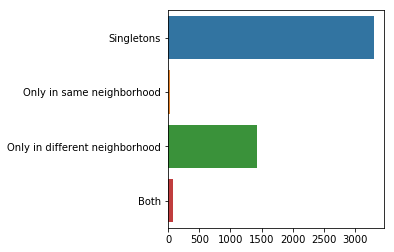

In [271]:
for c in dic_cluster: 
    if len(dic_cluster[c]['details']) == 1:
        dic_cluster[c]["type"] = "singleton"
    else: 
        nb_prot = len(dic_cluster[c]["details"])
        nox = set([p.split("+")[0] for p in dic_cluster[c]["details"]])
        if len(nox) == 1:
            dic_cluster[c]["type"] = "only_in_same_neighborhood"
        elif len(nox) == nb_prot : 
            dic_cluster[c]["type"] = "only_in_different_neighborhood"
        else: 
            dic_cluster[c]["type"] = "both"

nb_singleton = len([c for c in dic_cluster if dic_cluster[c]["type"] == "singleton"]) 
nb_same_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"]=="only_in_same_neighborhood"]) 
nb_unique_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"] == "only_in_different_neighborhood"]) 
nb_both = len([c for c in dic_cluster if dic_cluster[c]["type"] == "both"]) 
y = ["Singletons", "Only in same neighborhood", "Only in different neighborhood", "Both"]
x = [nb_singleton, nb_same_neighborhood, nb_unique_neighborhood, nb_both]
plot = sns.barplot(x,y)
plt.subplots_adjust(left=0.4)
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/clusters_types.pdf")
print("Singletons :", nb_singleton)
print("Only in same neighborhood :", nb_same_neighborhood)
print("Only in different neighborhood :", nb_unique_neighborhood)
print("In different neighborhood, at least two times in one of them :", nb_both)

In [272]:
uColl = uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot_neighbors")

Changing cache location to /Users/chilpert/cache/uniprot_neighbors
Reindexing /Users/chilpert/cache/uniprot_neighbors
Acknowledged 19235 entries (/Users/chilpert/cache/uniprot_neighbors)


In [273]:
for c in dic_cluster:
    for p in dic_cluster[c]["details"]: 
        p_id = p.split("+")[2].split(".")[0]
        try : 
            uniprot_entry=uColl.get(p_id, force_reading_cache = True)
        except:
            print(p, "not found")
            dic_cluster[c]["details"][p]["go"] = "uniprot not found"
            dic_cluster[c]["details"][p]["keywords"] = "uniprot not found"
            dic_cluster[c]["details"][p]["interpro"] = "uniprot not found"
            continue
        if not uniprot_entry.GO: 
            go = 'no uniprot go'
        else:    
            go = ";".join(sorted([go.term for go in uniprot_entry.GO]))
        if not uniprot_entry.KW:
            keywords = "no uniprot keywords"
        else:
            keywords = ";".join(sorted([kw.term for kw in uniprot_entry.KW if "proteome" not in kw.term]))
            if not keywords:
                keywords = "proteome"
        if not uniprot_entry.Interpro:
            interpro = "no interpro domains"
        else: 
            interpro = ";".join(sorted([i.id+":"+i.name for i in uniprot_entry.Interpro]))
        dic_cluster[c]["details"][p]["go"] = go
        dic_cluster[c]["details"][p]["keywords"] = keywords
        dic_cluster[c]["details"][p]["interpro"] = interpro

tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS455_Genome_element1+ASZ49468.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS459_Genome_element1+ASZ49471.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS449_Genome_element1+ASZ49462.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS462_Genome_element1+ASZ49474.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS447_Genome_element1+ASZ49460.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS463_Genome_element1+ASZ49475.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS445_Genome_element1+ASZ49458.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS444_Genome_element1+ASZ49457.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS450_Genome_element1+ASZ49463.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS451_Genome_element1+ASZ49464.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS458_Genome_element1+ASZ49470.1 not found


### Define annotation for clusters (at different level) and identify clusters to curate manually. 
Clusters can be annotate at several levels : 
* product : if all proteins of cluster have same product, product annotation is set. 
* uniprot keywords : common keywords among all proteins of cluster is kept for annotation 
* go term : common go term among all proteins of cluster is kept for annotation
* interpro : common interpro domain/family among all proteins of cluster is kept for annotation

A cluster has to be curate manually if no annotation level can be set. 

#### Add clusters information to topology container

In [274]:
data_uniprot = load("NOX_annotation_neighborhood10_20190829-111835.pickle")
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/neighbors_proteins_cluster.tsv")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle
restore a annotated container of  691 elements


#### Assign taxid and protein list to clusters

In [275]:
for c in dic_cluster:
    prot = [e for e in data_uniprot if c in e.neighborhood_clusters.values()]
    prot_name = [e.prot for e in prot]
    taxids = [e.taxo.taxid for e in prot]
    dic_cluster[c]["taxids"] = taxids
    dic_cluster[c]["nox"] = prot_name

In [276]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
for c in dic_cluster:
    tree = ncbi.get_topology(dic_cluster[c]["taxids"])
    dic_cluster[c]["upper"] = next(tree.traverse())

In [277]:
save(dic_cluster, "dic_cluster_c07")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_c07_20190829-160601.pickle


#### Annotate clusters

In [281]:
def minimize_annotation(list_annotation):
    '''Conserve only common annotation'''
    list_annotation = [l.split(";") for l in list_annotation]
    for l in list_annotation:
        for word in ["proteome", "no uniprot go", "no uniprot keywords", "no interpro domains", "uniprot not found"]:
            if word in l:
                l.remove(word)
            
    list_annotation = [l for l in list_annotation if l]
    if not list_annotation:
        minim_annotation = "no information"
    elif len(list_annotation) == 1:
        minim_annotation = ";".join(list_annotation[0])
    else:
        minim_annotation = get_similar(list_annotation)
        if not minim_annotation:
            return None
        minim_annotation = ";".join(sorted(list(minim_annotation)))
    return minim_annotation

In [230]:
def get_similar(list_words):
    '''Keep similar words among given lists'''
    words_to_keep = set(list_words[0])
    for i in range(1,len(list_words)):
        words_to_keep = words_to_keep.intersection(set(list_words[i]))
        #print("W",words_to_keep)
        if not words_to_keep: 
            return words_to_keep
    return words_to_keep

In [6]:
kw_annotation_dic = {}
product_annotation_dic = {}
go_annotation_dic = {}
interpro_annotation_dic = {}
for c in dic_cluster : 
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    
    kw_annotation = minimize_annotation(keywords)
    
    go_annotation = minimize_annotation(go)
    
    interpro_annotation = minimize_annotation(interpro)
    
    if kw_annotation:
        kw_annotation_dic[c] = kw_annotation
        
    if go_annotation:
        go_annotation_dic[c] = go_annotation
    
    if interpro_annotation:
        interpro_annotation_dic[c] = interpro_annotation
    
    if "hypothetical protein" in product:
        product.remove("hypothetical protein")
    
    if len(set(product)) == 0:
        product_annotation_dic[c] = "hypothetical protein"
    elif len(set(product)) == 1:
        product_annotation_dic[c] = product[0]

NameError: name 'dic_cluster' is not defined

In [284]:
o_name = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_list_annotated_name.txt" , "w")
for c in product_annotation_dic:
    o_name.write(str(c) + "\n")
o_name.close()
o_go = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_list_annotated_go.txt" , "w")
for c in go_annotation_dic:
    o_go.write(str(c) + "\n")
o_go.close()
o_kw = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_list_annotated_kw.txt" , "w")
for c in kw_annotation_dic:
    o_kw.write(str(c) + "\n")
o_kw.close()
o_interpro = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_list_annotated_interpro.txt" , "w")
for c in interpro_annotation_dic:
    o_interpro.write(str(c) + "\n")
o_interpro.close()

In [285]:
product_cluster = set(product_annotation_dic.keys())
go_cluster = set(go_annotation_dic.keys())
kw_cluster = set(kw_annotation_dic.keys())
interpro_cluster = set(interpro_annotation_dic.keys())
print(len(product_cluster), "with product annotation")
print(len(kw_cluster), "with keywords annotation")
print(len(go_cluster), "with go annotation")
print(len(interpro_cluster), "with interpro annotation")

3863 with product annotation
4775 with keywords annotation
4753 with go annotation
4830 with interpro annotation


8 cases : 
    * Just interpro annotation : 20 clusters
    * Keywords and go annotation : 1 cluster
    * Keywords and Interpro annotation : 48 clusters
    * GO and Interpro annotation : 25 clusters
    * Product, Keywords and Interpro annotation : 2 clusters 
    * Product, GO and Interpro annotation : 3 clusters 
    * Keywords, GO and Interpro annotation : 873 clusters
    * All annotations : 4131 clusters (included 3554 singletons)

In [286]:
c_interpro = interpro_cluster.difference(product_cluster).difference(go_cluster).difference(kw_cluster)
print(len(c_interpro))
c_kw_go = kw_cluster.intersection(go_cluster).difference(product_cluster).difference(interpro_cluster)
print(len(c_kw_go))
c_kw_interpro = kw_cluster.intersection(interpro_cluster).difference(product_cluster).difference(go_cluster)
print(len(c_kw_interpro))
c_go_interpro = go_cluster.intersection(interpro_cluster).difference(product_cluster).difference(kw_cluster)
print(len(c_go_interpro))
c_product_kw_interpro = product_cluster.intersection(interpro_cluster).intersection(kw_cluster).difference(go_cluster)
print(len(c_product_kw_interpro))
c_go_product_interpro = go_cluster.intersection(product_cluster).intersection(interpro_cluster).difference(kw_cluster)
print(len(c_go_product_interpro))
c_kw_go_interpro = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).difference(product_cluster)
print(len(c_kw_go_interpro))
c_all = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).intersection(product_cluster)
print(len(c_all))

23
2
52
29
3
4
863
3855


#### Write valid annotated clusters and detailed information on clusters

In [287]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/valid_annotation_clusters.tsv" , "w")
o.write("#Cluster\tNumber of proteins\tNumber of neighborhoods\tUpper node\tProduct\tKeywords\tGO\tInterpro\n")
detail = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/detailed_annotation_clusters.txt", "w")
to_check = set()
for c in dic_cluster: 
    detail.write("#Cluster" + str(c) + "\n")
    for p in dic_cluster[c]["details"]:
        p_id = p.split("+")[2]
        product = dic_cluster[c]["details"][p]["product"] 
        kw = dic_cluster[c]["details"][p]["keywords"] 
        go = dic_cluster[c]["details"][p]["go"] 
        interpro = dic_cluster[c]["details"][p]["interpro"]
        detail.write(p_id + "\t" + product + "\t" + kw + "\t" + go + "\t" + interpro + "\n")
    if c in product_annotation_dic or c in kw_annotation_dic or c in go_annotation_dic or c in interpro_annotation_dic: 
        neighborhood_number = len([e for e in data_uniprot if c in e.neighborhood_clusters.values()])
        upper_node = dic_cluster[c]["upper"].name+":"+dic_cluster[c]["upper"].sci_name
        o.write(str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\t" + str(neighborhood_number) + "\t" + 
                upper_node + "\t" +
                product_annotation_dic.get(c,"-") + "\t" + kw_annotation_dic.get(c,"-") + "\t" +
               go_annotation_dic.get(c,"-") + "\t" + interpro_annotation_dic.get(c,"-") + "\n")
    else: 
        to_check.add(c)
o.close()   
detail.close()

In [288]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/to_check_clusters.txt", "w")
for c in to_check:
    o.write("#Cluster" + str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\n")
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    product = sorted(product, key=lambda e:product.count(e), reverse = True)
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    keywords = sorted(keywords, key=lambda e:keywords.count(e), reverse = True)
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    go = sorted(go, key=lambda e:go.count(e), reverse = True)
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    interpro = sorted(interpro, key=lambda e:interpro.count(e), reverse = True)
    for p in set(product):
        o.write("P\t" + p + "\t" + str(product.count(p)) + "\n")
    for k in set(keywords):
        o.write("KW\t" + k + "\t" + str(keywords.count(k)) + "\n")
    for g in set(go):
        o.write("GO\t" + g + "\t" + str(go.count(g)) + "\n")
    for i in set(interpro):
        o.write("I\t" + i + "\t" + str(interpro.count(i)) + "\n")
o.close()

### Regroup same annotations
Regroup clusters with same annotation at each level

In [289]:
same_product = {}
same_keywords = {}
same_go = {}
same_interpro = {}
same_all = {}
all_annotation_dic = {}

def add_to_dic(dic,term,cluster):
    if term not in dic:
        dic[term] = []
    dic[term].append(cluster)    

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/valid_annotation_clusters.tsv", "r")
f.readline()
for l in f: 
    l_split = l.rstrip().split("\t")
    cluster = l_split[0] 
    product = l_split[4]
    kw = l_split[5]
    go = l_split[6]
    interpro = l_split[7]
    all = product + "+" + kw + "+" + go + "+" + interpro
    
    all_annotation_dic[int(cluster)] = all
    
    add_to_dic(same_product, product, cluster)
    add_to_dic(same_keywords, kw, cluster)
    add_to_dic(same_go, go, cluster)
    add_to_dic(same_interpro, interpro, cluster)
    add_to_dic(same_all, all, cluster)
    
f.close()
same_product = OrderedDict(sorted(same_product.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_keywords = OrderedDict(sorted(same_keywords.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_go = OrderedDict(sorted(same_go.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_interpro = OrderedDict(sorted(same_interpro.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_all = OrderedDict(sorted(same_all.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))

#### Write outputs

In [290]:
for e in data_uniprot:
    e.clusters_list = list(e.neighborhood_clusters.values())
    e.clusters_annotation = {}
    e.clusters_annotation["product"]=[product_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["keywords"]=[kw_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["go"]=[go_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["interpro"]=[interpro_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["all"]=[all_annotation_dic.get(c,"-") for c in e.clusters_list]

In [291]:
def write_same(file, dic, annotation_type):
    o = open(file,"w")
    o.write("#" + annotation_type + "\t" + "Number of clusters\tNumber of proteins\tNumber of neighborhoods\tUpper node\n")
    count = 0
    print("==",annotation_type)
    for w in dic:
        count += 1
        if count%100 == 0: 
            print(count,"/",len(dic))
        nb_proteins = sum([len(dic_cluster[int(c)]["details"]) for c in dic[w]])
        neighborhoods = set()
        for c in dic[w]:
            neighborhoods.update(dic_cluster[int(c)]["nox"])
        neighborhoods_taxids = [e.taxo.taxid for e in data_uniprot if e.prot in neighborhoods]    
        tree = ncbi.get_topology(neighborhoods_taxids)
        upper_node = next(tree.traverse())
        nb_neighborhoods = len(neighborhoods)
        nb_clusters = len(dic[w])
        o.write(w + "\t" + str(nb_clusters) + "\t" + str(nb_proteins) + "\t" + str(nb_neighborhoods) + "\t" + upper_node.name+":"+upper_node.sci_name + "\n")
    o.close()

write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_product.tsv", same_product, "product")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_keywords.tsv", same_keywords, "Keywords")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_go.tsv", same_go, "GO")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_interpro.tsv", same_interpro, "Interpro")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_all.tsv", same_all, "All annotation")

== product
100 / 1701
200 / 1701
300 / 1701
400 / 1701
500 / 1701
600 / 1701
700 / 1701
800 / 1701
900 / 1701
1000 / 1701
1100 / 1701
1200 / 1701
1300 / 1701
1400 / 1701
1500 / 1701
1600 / 1701
1700 / 1701
== Keywords
100 / 639
200 / 639
300 / 639
400 / 639
500 / 639
600 / 639
== GO
100 / 1179
200 / 1179
300 / 1179
400 / 1179
500 / 1179
600 / 1179
700 / 1179
800 / 1179
900 / 1179
1000 / 1179
1100 / 1179
== Interpro
100 / 2633
200 / 2633
300 / 2633
400 / 2633
500 / 2633
600 / 2633
700 / 2633
800 / 2633
900 / 2633
1000 / 2633
1100 / 2633
1200 / 2633
1300 / 2633
1400 / 2633
1500 / 2633
1600 / 2633
1700 / 2633
1800 / 2633
1900 / 2633
2000 / 2633
2100 / 2633
2200 / 2633
2300 / 2633
2400 / 2633
2500 / 2633
2600 / 2633
== All annotation
100 / 3543
200 / 3543
300 / 3543
400 / 3543
500 / 3543
600 / 3543
700 / 3543
800 / 3543
900 / 3543
1000 / 3543
1100 / 3543
1200 / 3543
1300 / 3543
1400 / 3543
1500 / 3543
1600 / 3543
1700 / 3543
1800 / 3543
1900 / 3543
2000 / 3543
2100 / 3543
2200 / 3543
2300 

## Test other clustering parameters

-s 2 : 5744 clusters  
-s 6 : 5103 clusters  
-s 9 : 4977 clusters  
-c 0.7 : 4832 clusters

```console

INITIAL_DIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood
WORKDIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5
mkdir -p $WORKDIR

mkdir -p $WORKDIR/clustering

mmseqs cluster $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/clustering/tmp_neighbors_proteins_cluster -c 0.5

mmseqs createtsv $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/neighbors_proteins_cluster.tsv --full-header 
```

In [292]:
from collections import OrderedDict
new_dic_cluster = {}
cluster_nb = 0
browse_representative = set()
f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/neighbors_proteins_cluster.tsv", "r")
for l in f:
    l_split = l.rstrip().split("\t")
    representative = l_split[0].split(" ")[0].strip('"')
    seq = l_split[1].split(" ")[0].strip('"')
    product = " ".join(l_split[1].split(" ")[1:]).strip('"').rstrip()
    if representative not in browse_representative:
        cluster_nb += 1
        browse_representative.add(representative)
    if cluster_nb not in new_dic_cluster:
        new_dic_cluster[cluster_nb] = {'details':{}}
    new_dic_cluster[cluster_nb]['details'][seq]={'product':product}   
f.close()

print(len(new_dic_cluster), "clusters created.")

new_dic_cluster = OrderedDict(sorted(new_dic_cluster.items(),
                                     key=lambda kv: len(kv[1]["details"]),
                                     reverse=True))

4460 clusters created.


In [293]:
print(len(dic_cluster))
print(len(new_dic_cluster))

4832
4460


In [253]:
print(new_dic_cluster[1])
print()
print(dic_cluster[1001])

clusters1 = set(new_dic_cluster[1]["details"].keys())
clusters2 = set(dic_cluster[1001]["details"].keys())

print(len(clusters1))
print(len(clusters2))
print(clusters1.intersection(clusters2))

{'details': {'tr|L2VL28|L2VL28_ECOLX+CDS259_Genome_element6+ELC15135.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0XWD8|S0XWD8_ECOLX+CDS94_Genome_element38+EOU90169.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|V2RUN2|V2RUN2_ECOLX+CDS81_Genome_element15+ESK15565.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|T6LZV0|T6LZV0_ECOLX+CDS25_Genome_element37+EQQ04042.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|A0A0K4AXW7|A0A0K4AXW7_ECOLX+CDS67_Genome_element13+CTT95444.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|B7N7G0|B7N7G0_ECOLU+CDS3185_Genome_element1+CAR14412.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase,FAD/NAD(P)-binding'}, 'tr|B1LDB9|B1LDB9_ECOSM+CDS2944_Genome_element1+ACB16805.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0YK37|S0YK37_ECOLX+CDS20_Genome_element80+EOV04556.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|D7X1Q2|D7X1Q2_ECOL

In [267]:
def correspondance_clusters(new_clusters, old_clusters):
    i = 0
    for c in new_clusters:
        i += 1
        clusters1 = set(new_clusters[c]["details"].keys())
        for c2 in old_clusters:
            clusters2 = set(old_clusters[c2]["details"].keys())
            #print(clusters1, clusters2)
            if clusters1 == clusters2:
                print("OO", c, c2)
            elif clusters1.intersection(clusters2):
                print("AA", c, c2)
        if i == 10:
            break

In [268]:
correspondance_clusters(new_dic_cluster, dic_cluster)

OO 3747 2395
AA 25 4439
AA 25 324
AA 25 4551
AA 25 4713
AA 25 1010
AA 25 1842
AA 2330 4577
AA 4534 4421
AA 4534 3641
AA 4534 3067
AA 4534 3281
AA 4534 5030
OO 302 1371
AA 3312 895
AA 3312 1034
AA 3312 1750
AA 3312 1060
OO 3777 2429
AA 2750 1254
AA 2750 4114
AA 2750 2899
OO 8 1007
AA 6 1005
AA 6 3787


In [294]:
dic_cluster = new_dic_cluster

Singletons : 2937
Only in same neighborhood : 31
Only in different neighborhood : 1399
In different neighborhood, at least two times in one of them : 93


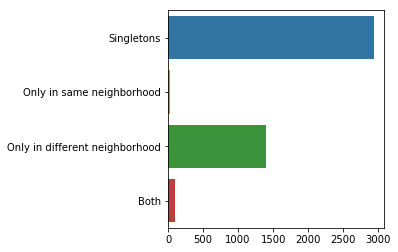

In [295]:
for c in dic_cluster: 
    if len(dic_cluster[c]['details']) == 1:
        dic_cluster[c]["type"] = "singleton"
    else: 
        nb_prot = len(dic_cluster[c]["details"])
        nox = set([p.split("+")[0] for p in dic_cluster[c]["details"]])
        if len(nox) == 1:
            dic_cluster[c]["type"] = "only_in_same_neighborhood"
        elif len(nox) == nb_prot : 
            dic_cluster[c]["type"] = "only_in_different_neighborhood"
        else: 
            dic_cluster[c]["type"] = "both"

nb_singleton = len([c for c in dic_cluster if dic_cluster[c]["type"] == "singleton"]) 
nb_same_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"]=="only_in_same_neighborhood"]) 
nb_unique_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"] == "only_in_different_neighborhood"]) 
nb_both = len([c for c in dic_cluster if dic_cluster[c]["type"] == "both"]) 
y = ["Singletons", "Only in same neighborhood", "Only in different neighborhood", "Both"]
x = [nb_singleton, nb_same_neighborhood, nb_unique_neighborhood, nb_both]
plot = sns.barplot(x,y)
plt.subplots_adjust(left=0.4)
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/clusters_types.pdf")
print("Singletons :", nb_singleton)
print("Only in same neighborhood :", nb_same_neighborhood)
print("Only in different neighborhood :", nb_unique_neighborhood)
print("In different neighborhood, at least two times in one of them :", nb_both)

In [296]:
uColl = uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot_neighbors")

Changing cache location to /Users/chilpert/cache/uniprot_neighbors
Reindexing /Users/chilpert/cache/uniprot_neighbors
Acknowledged 19235 entries (/Users/chilpert/cache/uniprot_neighbors)


In [297]:
for c in dic_cluster:
    for p in dic_cluster[c]["details"]: 
        p_id = p.split("+")[2].split(".")[0]
        try : 
            uniprot_entry=uColl.get(p_id, force_reading_cache = True)
        except:
            print(p, "not found")
            dic_cluster[c]["details"][p]["go"] = "uniprot not found"
            dic_cluster[c]["details"][p]["keywords"] = "uniprot not found"
            dic_cluster[c]["details"][p]["interpro"] = "uniprot not found"
            continue
        if not uniprot_entry.GO: 
            go = 'no uniprot go'
        else:    
            go = ";".join(sorted([go.term for go in uniprot_entry.GO]))
        if not uniprot_entry.KW:
            keywords = "no uniprot keywords"
        else:
            keywords = ";".join(sorted([kw.term for kw in uniprot_entry.KW if "proteome" not in kw.term]))
            if not keywords:
                keywords = "proteome"
        if not uniprot_entry.Interpro:
            interpro = "no interpro domains"
        else: 
            interpro = ";".join(sorted([i.id+":"+i.name for i in uniprot_entry.Interpro]))
        dic_cluster[c]["details"][p]["go"] = go
        dic_cluster[c]["details"][p]["keywords"] = keywords
        dic_cluster[c]["details"][p]["interpro"] = interpro

tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS455_Genome_element1+ASZ49468.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS459_Genome_element1+ASZ49471.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS451_Genome_element1+ASZ49464.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS449_Genome_element1+ASZ49462.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS462_Genome_element1+ASZ49474.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS447_Genome_element1+ASZ49460.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS463_Genome_element1+ASZ49475.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS445_Genome_element1+ASZ49458.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS444_Genome_element1+ASZ49457.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS450_Genome_element1+ASZ49463.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS458_Genome_element1+ASZ49470.1 not found


### Define annotation for clusters (at different level) and identify clusters to curate manually. 
Clusters can be annotate at several levels : 
* product : if all proteins of cluster have same product, product annotation is set. 
* uniprot keywords : common keywords among all proteins of cluster is kept for annotation 
* go term : common go term among all proteins of cluster is kept for annotation
* interpro : common interpro domain/family among all proteins of cluster is kept for annotation

A cluster has to be curate manually if no annotation level can be set. 

#### Add clusters information to topology container

In [298]:
data_uniprot = load("NOX_annotation_neighborhood10_20190829-111835.pickle")
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/neighbors_proteins_cluster.tsv")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle
restore a annotated container of  691 elements


#### Assign taxid and protein list to clusters

In [299]:
for c in dic_cluster:
    prot = [e for e in data_uniprot if c in e.neighborhood_clusters.values()]
    prot_name = [e.prot for e in prot]
    taxids = [e.taxo.taxid for e in prot]
    dic_cluster[c]["taxids"] = taxids
    dic_cluster[c]["nox"] = prot_name

In [300]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
for c in dic_cluster:
    tree = ncbi.get_topology(dic_cluster[c]["taxids"])
    dic_cluster[c]["upper"] = next(tree.traverse())

In [301]:
save(dic_cluster, "dic_cluster_c05")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_c05_20190829-164748.pickle


#### Annotate clusters

In [302]:
def minimize_annotation(list_annotation):
    '''Conserve only common annotation'''
    list_annotation = [l.split(";") for l in list_annotation]
    for l in list_annotation:
        for word in ["proteome", "no uniprot go", "no uniprot keywords", "no interpro domains", "uniprot not found"]:
            if word in l:
                l.remove(word)
            
    list_annotation = [l for l in list_annotation if l]
    if not list_annotation:
        minim_annotation = "no information"
    elif len(list_annotation) == 1:
        minim_annotation = ";".join(list_annotation[0])
    else:
        minim_annotation = get_similar(list_annotation)
        if not minim_annotation:
            return None
        minim_annotation = ";".join(sorted(list(minim_annotation)))
    return minim_annotation

In [303]:
def get_similar(list_words):
    '''Keep similar words among given lists'''
    words_to_keep = set(list_words[0])
    for i in range(1,len(list_words)):
        words_to_keep = words_to_keep.intersection(set(list_words[i]))
        #print("W",words_to_keep)
        if not words_to_keep: 
            return words_to_keep
    return words_to_keep

In [304]:
kw_annotation_dic = {}
product_annotation_dic = {}
go_annotation_dic = {}
interpro_annotation_dic = {}
for c in dic_cluster : 
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    
    kw_annotation = minimize_annotation(keywords)
    
    go_annotation = minimize_annotation(go)
    
    interpro_annotation = minimize_annotation(interpro)
    
    if kw_annotation:
        kw_annotation_dic[c] = kw_annotation
        
    if go_annotation:
        go_annotation_dic[c] = go_annotation
    
    if interpro_annotation:
        interpro_annotation_dic[c] = interpro_annotation
    
    if "hypothetical protein" in product:
        product.remove("hypothetical protein")
    
    if len(set(product)) == 0:
        product_annotation_dic[c] = "hypothetical protein"
    elif len(set(product)) == 1:
        product_annotation_dic[c] = product[0]

In [305]:
o_name = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/clusters_list_annotated_name.txt" , "w")
for c in product_annotation_dic:
    o_name.write(str(c) + "\n")
o_name.close()
o_go = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/clusters_list_annotated_go.txt" , "w")
for c in go_annotation_dic:
    o_go.write(str(c) + "\n")
o_go.close()
o_kw = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/clusters_list_annotated_kw.txt" , "w")
for c in kw_annotation_dic:
    o_kw.write(str(c) + "\n")
o_kw.close()
o_interpro = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/clusters_list_annotated_interpro.txt" , "w")
for c in interpro_annotation_dic:
    o_interpro.write(str(c) + "\n")
o_interpro.close()

In [306]:
product_cluster = set(product_annotation_dic.keys())
go_cluster = set(go_annotation_dic.keys())
kw_cluster = set(kw_annotation_dic.keys())
interpro_cluster = set(interpro_annotation_dic.keys())
print(len(product_cluster), "with product annotation")
print(len(kw_cluster), "with keywords annotation")
print(len(go_cluster), "with go annotation")
print(len(interpro_cluster), "with interpro annotation")

3479 with product annotation
4379 with keywords annotation
4353 with go annotation
4455 with interpro annotation


8 cases : 
    * Just interpro annotation : 20 clusters
    * Keywords and go annotation : 1 cluster
    * Keywords and Interpro annotation : 48 clusters
    * GO and Interpro annotation : 25 clusters
    * Product, Keywords and Interpro annotation : 2 clusters 
    * Product, GO and Interpro annotation : 3 clusters 
    * Keywords, GO and Interpro annotation : 873 clusters
    * All annotations : 4131 clusters (included 3554 singletons)

In [307]:
c_interpro = interpro_cluster.difference(product_cluster).difference(go_cluster).difference(kw_cluster)
print(len(c_interpro))
c_kw_go = kw_cluster.intersection(go_cluster).difference(product_cluster).difference(interpro_cluster)
print(len(c_kw_go))
c_kw_interpro = kw_cluster.intersection(interpro_cluster).difference(product_cluster).difference(go_cluster)
print(len(c_kw_interpro))
c_go_interpro = go_cluster.intersection(interpro_cluster).difference(product_cluster).difference(kw_cluster)
print(len(c_go_interpro))
c_product_kw_interpro = product_cluster.intersection(interpro_cluster).intersection(kw_cluster).difference(go_cluster)
print(len(c_product_kw_interpro))
c_go_product_interpro = go_cluster.intersection(product_cluster).intersection(interpro_cluster).difference(kw_cluster)
print(len(c_go_product_interpro))
c_kw_go_interpro = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).difference(product_cluster)
print(len(c_kw_go_interpro))
c_all = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).intersection(product_cluster)
print(len(c_all))

32
5
67
41
5
5
836
3466


#### Write valid annotated clusters and detailed information on clusters

In [308]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/valid_annotation_clusters.tsv" , "w")
o.write("#Cluster\tNumber of proteins\tNumber of neighborhoods\tUpper node\tProduct\tKeywords\tGO\tInterpro\n")
detail = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/detailed_annotation_clusters.txt", "w")
to_check = set()
for c in dic_cluster: 
    detail.write("#Cluster" + str(c) + "\n")
    for p in dic_cluster[c]["details"]:
        p_id = p.split("+")[2]
        product = dic_cluster[c]["details"][p]["product"] 
        kw = dic_cluster[c]["details"][p]["keywords"] 
        go = dic_cluster[c]["details"][p]["go"] 
        interpro = dic_cluster[c]["details"][p]["interpro"]
        detail.write(p_id + "\t" + product + "\t" + kw + "\t" + go + "\t" + interpro + "\n")
    if c in product_annotation_dic or c in kw_annotation_dic or c in go_annotation_dic or c in interpro_annotation_dic: 
        neighborhood_number = len([e for e in data_uniprot if c in e.neighborhood_clusters.values()])
        upper_node = dic_cluster[c]["upper"].name+":"+dic_cluster[c]["upper"].sci_name
        o.write(str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\t" + str(neighborhood_number) + "\t" + 
                upper_node + "\t" +
                product_annotation_dic.get(c,"-") + "\t" + kw_annotation_dic.get(c,"-") + "\t" +
               go_annotation_dic.get(c,"-") + "\t" + interpro_annotation_dic.get(c,"-") + "\n")
    else: 
        to_check.add(c)
o.close()   
detail.close()

In [309]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/to_check_clusters.txt", "w")
for c in to_check:
    o.write("#Cluster" + str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\n")
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    product = sorted(product, key=lambda e:product.count(e), reverse = True)
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    keywords = sorted(keywords, key=lambda e:keywords.count(e), reverse = True)
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    go = sorted(go, key=lambda e:go.count(e), reverse = True)
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    interpro = sorted(interpro, key=lambda e:interpro.count(e), reverse = True)
    for p in set(product):
        o.write("P\t" + p + "\t" + str(product.count(p)) + "\n")
    for k in set(keywords):
        o.write("KW\t" + k + "\t" + str(keywords.count(k)) + "\n")
    for g in set(go):
        o.write("GO\t" + g + "\t" + str(go.count(g)) + "\n")
    for i in set(interpro):
        o.write("I\t" + i + "\t" + str(interpro.count(i)) + "\n")
o.close()

### Regroup same annotations
Regroup clusters with same annotation at each level

In [310]:
same_product = {}
same_keywords = {}
same_go = {}
same_interpro = {}
same_all = {}
all_annotation_dic = {}

def add_to_dic(dic,term,cluster):
    if term not in dic:
        dic[term] = []
    dic[term].append(cluster)    

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/valid_annotation_clusters.tsv", "r")
f.readline()
for l in f: 
    l_split = l.rstrip().split("\t")
    cluster = l_split[0] 
    product = l_split[4]
    kw = l_split[5]
    go = l_split[6]
    interpro = l_split[7]
    all = product + "+" + kw + "+" + go + "+" + interpro
    
    all_annotation_dic[int(cluster)] = all
    
    add_to_dic(same_product, product, cluster)
    add_to_dic(same_keywords, kw, cluster)
    add_to_dic(same_go, go, cluster)
    add_to_dic(same_interpro, interpro, cluster)
    add_to_dic(same_all, all, cluster)
    
f.close()
same_product = OrderedDict(sorted(same_product.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_keywords = OrderedDict(sorted(same_keywords.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_go = OrderedDict(sorted(same_go.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_interpro = OrderedDict(sorted(same_interpro.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_all = OrderedDict(sorted(same_all.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))

#### Write outputs

In [311]:
for e in data_uniprot:
    e.clusters_list = list(e.neighborhood_clusters.values())
    e.clusters_annotation = {}
    e.clusters_annotation["product"]=[product_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["keywords"]=[kw_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["go"]=[go_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["interpro"]=[interpro_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["all"]=[all_annotation_dic.get(c,"-") for c in e.clusters_list]

In [312]:
def write_same(file, dic, annotation_type):
    o = open(file,"w")
    o.write("#" + annotation_type + "\t" + "Number of clusters\tNumber of proteins\tNumber of neighborhoods\tUpper node\n")
    count = 0
    print("==",annotation_type)
    for w in dic:
        count += 1
        if count%100 == 0: 
            print(count,"/",len(dic))
        nb_proteins = sum([len(dic_cluster[int(c)]["details"]) for c in dic[w]])
        neighborhoods = set()
        for c in dic[w]:
            neighborhoods.update(dic_cluster[int(c)]["nox"])
        neighborhoods_taxids = [e.taxo.taxid for e in data_uniprot if e.prot in neighborhoods]    
        tree = ncbi.get_topology(neighborhoods_taxids)
        upper_node = next(tree.traverse())
        nb_neighborhoods = len(neighborhoods)
        nb_clusters = len(dic[w])
        o.write(w + "\t" + str(nb_clusters) + "\t" + str(nb_proteins) + "\t" + str(nb_neighborhoods) + "\t" + upper_node.name+":"+upper_node.sci_name + "\n")
    o.close()

write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c5/clusters_annotations_same_product.tsv", same_product, "product")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_keywords.tsv", same_keywords, "Keywords")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_go.tsv", same_go, "GO")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_interpro.tsv", same_interpro, "Interpro")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_all.tsv", same_all, "All annotation")

== product
100 / 1505
200 / 1505
300 / 1505
400 / 1505
500 / 1505
600 / 1505
700 / 1505
800 / 1505
900 / 1505
1000 / 1505
1100 / 1505
1200 / 1505
1300 / 1505
1400 / 1505
1500 / 1505


## Test other clustering parameters

-s 2 : 5744 clusters  
-s 6 : 5103 clusters  
-s 9 : 4977 clusters  
-c 0.7 : 4832 clusters

```console

INITIAL_DIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood
WORKDIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1
mkdir -p $WORKDIR

mkdir -p $WORKDIR/clustering

mmseqs cluster $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/clustering/tmp_neighbors_proteins_cluster -c 0.1

mmseqs createtsv $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $INITIAL_DIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/neighbors_proteins_cluster.tsv --full-header 
```

In [313]:
from collections import OrderedDict
new_dic_cluster = {}
cluster_nb = 0
browse_representative = set()
f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/neighbors_proteins_cluster.tsv", "r")
for l in f:
    l_split = l.rstrip().split("\t")
    representative = l_split[0].split(" ")[0].strip('"')
    seq = l_split[1].split(" ")[0].strip('"')
    product = " ".join(l_split[1].split(" ")[1:]).strip('"').rstrip()
    if representative not in browse_representative:
        cluster_nb += 1
        browse_representative.add(representative)
    if cluster_nb not in new_dic_cluster:
        new_dic_cluster[cluster_nb] = {'details':{}}
    new_dic_cluster[cluster_nb]['details'][seq]={'product':product}   
f.close()

print(len(new_dic_cluster), "clusters created.")

new_dic_cluster = OrderedDict(sorted(new_dic_cluster.items(),
                                     key=lambda kv: len(kv[1]["details"]),
                                     reverse=True))

3976 clusters created.


In [314]:
print(len(dic_cluster))
print(len(new_dic_cluster))

4460
3976


In [253]:
print(new_dic_cluster[1])
print()
print(dic_cluster[1001])

clusters1 = set(new_dic_cluster[1]["details"].keys())
clusters2 = set(dic_cluster[1001]["details"].keys())

print(len(clusters1))
print(len(clusters2))
print(clusters1.intersection(clusters2))

{'details': {'tr|L2VL28|L2VL28_ECOLX+CDS259_Genome_element6+ELC15135.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0XWD8|S0XWD8_ECOLX+CDS94_Genome_element38+EOU90169.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|V2RUN2|V2RUN2_ECOLX+CDS81_Genome_element15+ESK15565.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|T6LZV0|T6LZV0_ECOLX+CDS25_Genome_element37+EQQ04042.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|A0A0K4AXW7|A0A0K4AXW7_ECOLX+CDS67_Genome_element13+CTT95444.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|B7N7G0|B7N7G0_ECOLU+CDS3185_Genome_element1+CAR14412.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase,FAD/NAD(P)-binding'}, 'tr|B1LDB9|B1LDB9_ECOSM+CDS2944_Genome_element1+ACB16805.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|S0YK37|S0YK37_ECOLX+CDS20_Genome_element80+EOV04556.1': {'product': '2-octaprenyl-6-methoxyphenol hydroxylase'}, 'tr|D7X1Q2|D7X1Q2_ECOL

In [267]:
def correspondance_clusters(new_clusters, old_clusters):
    i = 0
    for c in new_clusters:
        i += 1
        clusters1 = set(new_clusters[c]["details"].keys())
        for c2 in old_clusters:
            clusters2 = set(old_clusters[c2]["details"].keys())
            #print(clusters1, clusters2)
            if clusters1 == clusters2:
                print("OO", c, c2)
            elif clusters1.intersection(clusters2):
                print("AA", c, c2)
        if i == 10:
            break

In [268]:
correspondance_clusters(new_dic_cluster, dic_cluster)

OO 3747 2395
AA 25 4439
AA 25 324
AA 25 4551
AA 25 4713
AA 25 1010
AA 25 1842
AA 2330 4577
AA 4534 4421
AA 4534 3641
AA 4534 3067
AA 4534 3281
AA 4534 5030
OO 302 1371
AA 3312 895
AA 3312 1034
AA 3312 1750
AA 3312 1060
OO 3777 2429
AA 2750 1254
AA 2750 4114
AA 2750 2899
OO 8 1007
AA 6 1005
AA 6 3787


In [315]:
dic_cluster = new_dic_cluster

Singletons : 2470
Only in same neighborhood : 40
Only in different neighborhood : 1326
In different neighborhood, at least two times in one of them : 140


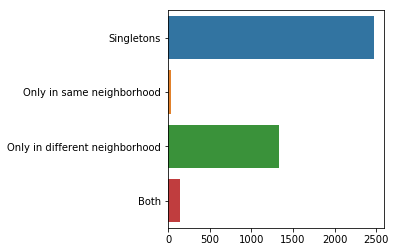

In [316]:
for c in dic_cluster: 
    if len(dic_cluster[c]['details']) == 1:
        dic_cluster[c]["type"] = "singleton"
    else: 
        nb_prot = len(dic_cluster[c]["details"])
        nox = set([p.split("+")[0] for p in dic_cluster[c]["details"]])
        if len(nox) == 1:
            dic_cluster[c]["type"] = "only_in_same_neighborhood"
        elif len(nox) == nb_prot : 
            dic_cluster[c]["type"] = "only_in_different_neighborhood"
        else: 
            dic_cluster[c]["type"] = "both"

nb_singleton = len([c for c in dic_cluster if dic_cluster[c]["type"] == "singleton"]) 
nb_same_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"]=="only_in_same_neighborhood"]) 
nb_unique_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"] == "only_in_different_neighborhood"]) 
nb_both = len([c for c in dic_cluster if dic_cluster[c]["type"] == "both"]) 
y = ["Singletons", "Only in same neighborhood", "Only in different neighborhood", "Both"]
x = [nb_singleton, nb_same_neighborhood, nb_unique_neighborhood, nb_both]
plot = sns.barplot(x,y)
plt.subplots_adjust(left=0.4)
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/clusters_types.pdf")
print("Singletons :", nb_singleton)
print("Only in same neighborhood :", nb_same_neighborhood)
print("Only in different neighborhood :", nb_unique_neighborhood)
print("In different neighborhood, at least two times in one of them :", nb_both)

In [317]:
uColl = uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot_neighbors")

Changing cache location to /Users/chilpert/cache/uniprot_neighbors
Reindexing /Users/chilpert/cache/uniprot_neighbors
Acknowledged 19235 entries (/Users/chilpert/cache/uniprot_neighbors)


In [318]:
for c in dic_cluster:
    for p in dic_cluster[c]["details"]: 
        p_id = p.split("+")[2].split(".")[0]
        try : 
            uniprot_entry=uColl.get(p_id, force_reading_cache = True)
        except:
            print(p, "not found")
            dic_cluster[c]["details"][p]["go"] = "uniprot not found"
            dic_cluster[c]["details"][p]["keywords"] = "uniprot not found"
            dic_cluster[c]["details"][p]["interpro"] = "uniprot not found"
            continue
        if not uniprot_entry.GO: 
            go = 'no uniprot go'
        else:    
            go = ";".join(sorted([go.term for go in uniprot_entry.GO]))
        if not uniprot_entry.KW:
            keywords = "no uniprot keywords"
        else:
            keywords = ";".join(sorted([kw.term for kw in uniprot_entry.KW if "proteome" not in kw.term]))
            if not keywords:
                keywords = "proteome"
        if not uniprot_entry.Interpro:
            interpro = "no interpro domains"
        else: 
            interpro = ";".join(sorted([i.id+":"+i.name for i in uniprot_entry.Interpro]))
        dic_cluster[c]["details"][p]["go"] = go
        dic_cluster[c]["details"][p]["keywords"] = keywords
        dic_cluster[c]["details"][p]["interpro"] = interpro

tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS455_Genome_element1+ASZ49468.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS451_Genome_element1+ASZ49464.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS459_Genome_element1+ASZ49471.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS449_Genome_element1+ASZ49462.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS447_Genome_element1+ASZ49460.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS462_Genome_element1+ASZ49474.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS463_Genome_element1+ASZ49475.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS450_Genome_element1+ASZ49463.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS444_Genome_element1+ASZ49457.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS445_Genome_element1+ASZ49458.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS458_Genome_element1+ASZ49470.1 not found


### Define annotation for clusters (at different level) and identify clusters to curate manually. 
Clusters can be annotate at several levels : 
* product : if all proteins of cluster have same product, product annotation is set. 
* uniprot keywords : common keywords among all proteins of cluster is kept for annotation 
* go term : common go term among all proteins of cluster is kept for annotation
* interpro : common interpro domain/family among all proteins of cluster is kept for annotation

A cluster has to be curate manually if no annotation level can be set. 

#### Add clusters information to topology container

In [319]:
data_uniprot = load("NOX_annotation_neighborhood10_20190829-111835.pickle")
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/neighbors_proteins_cluster.tsv")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190829-111835.pickle
restore a annotated container of  691 elements


#### Assign taxid and protein list to clusters

In [320]:
for c in dic_cluster:
    prot = [e for e in data_uniprot if c in e.neighborhood_clusters.values()]
    prot_name = [e.prot for e in prot]
    taxids = [e.taxo.taxid for e in prot]
    dic_cluster[c]["taxids"] = taxids
    dic_cluster[c]["nox"] = prot_name

In [321]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
for c in dic_cluster:
    tree = ncbi.get_topology(dic_cluster[c]["taxids"])
    dic_cluster[c]["upper"] = next(tree.traverse())

In [322]:
save(dic_cluster, "dic_cluster_c01")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_c01_20190829-171220.pickle


#### Annotate clusters

In [323]:
def minimize_annotation(list_annotation):
    '''Conserve only common annotation'''
    list_annotation = [l.split(";") for l in list_annotation]
    for l in list_annotation:
        for word in ["proteome", "no uniprot go", "no uniprot keywords", "no interpro domains", "uniprot not found"]:
            if word in l:
                l.remove(word)
            
    list_annotation = [l for l in list_annotation if l]
    if not list_annotation:
        minim_annotation = "no information"
    elif len(list_annotation) == 1:
        minim_annotation = ";".join(list_annotation[0])
    else:
        minim_annotation = get_similar(list_annotation)
        if not minim_annotation:
            return None
        minim_annotation = ";".join(sorted(list(minim_annotation)))
    return minim_annotation

In [324]:
def get_similar(list_words):
    '''Keep similar words among given lists'''
    words_to_keep = set(list_words[0])
    for i in range(1,len(list_words)):
        words_to_keep = words_to_keep.intersection(set(list_words[i]))
        #print("W",words_to_keep)
        if not words_to_keep: 
            return words_to_keep
    return words_to_keep

In [325]:
kw_annotation_dic = {}
product_annotation_dic = {}
go_annotation_dic = {}
interpro_annotation_dic = {}
for c in dic_cluster : 
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    
    kw_annotation = minimize_annotation(keywords)
    
    go_annotation = minimize_annotation(go)
    
    interpro_annotation = minimize_annotation(interpro)
    
    if kw_annotation:
        kw_annotation_dic[c] = kw_annotation
        
    if go_annotation:
        go_annotation_dic[c] = go_annotation
    
    if interpro_annotation:
        interpro_annotation_dic[c] = interpro_annotation
    
    if "hypothetical protein" in product:
        product.remove("hypothetical protein")
    
    if len(set(product)) == 0:
        product_annotation_dic[c] = "hypothetical protein"
    elif len(set(product)) == 1:
        product_annotation_dic[c] = product[0]

In [326]:
o_name = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/clusters_list_annotated_name.txt" , "w")
for c in product_annotation_dic:
    o_name.write(str(c) + "\n")
o_name.close()
o_go = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/clusters_list_annotated_go.txt" , "w")
for c in go_annotation_dic:
    o_go.write(str(c) + "\n")
o_go.close()
o_kw = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/clusters_list_annotated_kw.txt" , "w")
for c in kw_annotation_dic:
    o_kw.write(str(c) + "\n")
o_kw.close()
o_interpro = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/clusters_list_annotated_interpro.txt" , "w")
for c in interpro_annotation_dic:
    o_interpro.write(str(c) + "\n")
o_interpro.close()

In [327]:
product_cluster = set(product_annotation_dic.keys())
go_cluster = set(go_annotation_dic.keys())
kw_cluster = set(kw_annotation_dic.keys())
interpro_cluster = set(interpro_annotation_dic.keys())
print(len(product_cluster), "with product annotation")
print(len(kw_cluster), "with keywords annotation")
print(len(go_cluster), "with go annotation")
print(len(interpro_cluster), "with interpro annotation")

2984 with product annotation
3855 with keywords annotation
3829 with go annotation
3932 with interpro annotation


8 cases : 
    * Just interpro annotation : 20 clusters
    * Keywords and go annotation : 1 cluster
    * Keywords and Interpro annotation : 48 clusters
    * GO and Interpro annotation : 25 clusters
    * Product, Keywords and Interpro annotation : 2 clusters 
    * Product, GO and Interpro annotation : 3 clusters 
    * Keywords, GO and Interpro annotation : 873 clusters
    * All annotations : 4131 clusters (included 3554 singletons)

In [328]:
c_interpro = interpro_cluster.difference(product_cluster).difference(go_cluster).difference(kw_cluster)
print(len(c_interpro))
c_kw_go = kw_cluster.intersection(go_cluster).difference(product_cluster).difference(interpro_cluster)
print(len(c_kw_go))
c_kw_interpro = kw_cluster.intersection(interpro_cluster).difference(product_cluster).difference(go_cluster)
print(len(c_kw_interpro))
c_go_interpro = go_cluster.intersection(interpro_cluster).difference(product_cluster).difference(kw_cluster)
print(len(c_go_interpro))
c_product_kw_interpro = product_cluster.intersection(interpro_cluster).intersection(kw_cluster).difference(go_cluster)
print(len(c_product_kw_interpro))
c_go_product_interpro = go_cluster.intersection(product_cluster).intersection(interpro_cluster).difference(kw_cluster)
print(len(c_go_product_interpro))
c_kw_go_interpro = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).difference(product_cluster)
print(len(c_kw_go_interpro))
c_all = kw_cluster.intersection(go_cluster).intersection(interpro_cluster).intersection(product_cluster)
print(len(c_all))

42
16
80
47
4
10
781
2968


#### Write valid annotated clusters and detailed information on clusters

In [329]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/valid_annotation_clusters.tsv" , "w")
o.write("#Cluster\tNumber of proteins\tNumber of neighborhoods\tUpper node\tProduct\tKeywords\tGO\tInterpro\n")
detail = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/detailed_annotation_clusters.txt", "w")
to_check = set()
for c in dic_cluster: 
    detail.write("#Cluster" + str(c) + "\n")
    for p in dic_cluster[c]["details"]:
        p_id = p.split("+")[2]
        product = dic_cluster[c]["details"][p]["product"] 
        kw = dic_cluster[c]["details"][p]["keywords"] 
        go = dic_cluster[c]["details"][p]["go"] 
        interpro = dic_cluster[c]["details"][p]["interpro"]
        detail.write(p_id + "\t" + product + "\t" + kw + "\t" + go + "\t" + interpro + "\n")
    if c in product_annotation_dic or c in kw_annotation_dic or c in go_annotation_dic or c in interpro_annotation_dic: 
        neighborhood_number = len([e for e in data_uniprot if c in e.neighborhood_clusters.values()])
        upper_node = dic_cluster[c]["upper"].name+":"+dic_cluster[c]["upper"].sci_name
        o.write(str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\t" + str(neighborhood_number) + "\t" + 
                upper_node + "\t" +
                product_annotation_dic.get(c,"-") + "\t" + kw_annotation_dic.get(c,"-") + "\t" +
               go_annotation_dic.get(c,"-") + "\t" + interpro_annotation_dic.get(c,"-") + "\n")
    else: 
        to_check.add(c)
o.close()   
detail.close()

In [330]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/to_check_clusters.txt", "w")
for c in to_check:
    o.write("#Cluster" + str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\n")
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    product = sorted(product, key=lambda e:product.count(e), reverse = True)
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    keywords = sorted(keywords, key=lambda e:keywords.count(e), reverse = True)
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    go = sorted(go, key=lambda e:go.count(e), reverse = True)
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    interpro = sorted(interpro, key=lambda e:interpro.count(e), reverse = True)
    for p in set(product):
        o.write("P\t" + p + "\t" + str(product.count(p)) + "\n")
    for k in set(keywords):
        o.write("KW\t" + k + "\t" + str(keywords.count(k)) + "\n")
    for g in set(go):
        o.write("GO\t" + g + "\t" + str(go.count(g)) + "\n")
    for i in set(interpro):
        o.write("I\t" + i + "\t" + str(interpro.count(i)) + "\n")
o.close()

### Regroup same annotations
Regroup clusters with same annotation at each level

In [331]:
same_product = {}
same_keywords = {}
same_go = {}
same_interpro = {}
same_all = {}
all_annotation_dic = {}

def add_to_dic(dic,term,cluster):
    if term not in dic:
        dic[term] = []
    dic[term].append(cluster)    

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/valid_annotation_clusters.tsv", "r")
f.readline()
for l in f: 
    l_split = l.rstrip().split("\t")
    cluster = l_split[0] 
    product = l_split[4]
    kw = l_split[5]
    go = l_split[6]
    interpro = l_split[7]
    all = product + "+" + kw + "+" + go + "+" + interpro
    
    all_annotation_dic[int(cluster)] = all
    
    add_to_dic(same_product, product, cluster)
    add_to_dic(same_keywords, kw, cluster)
    add_to_dic(same_go, go, cluster)
    add_to_dic(same_interpro, interpro, cluster)
    add_to_dic(same_all, all, cluster)
    
f.close()
same_product = OrderedDict(sorted(same_product.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_keywords = OrderedDict(sorted(same_keywords.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_go = OrderedDict(sorted(same_go.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_interpro = OrderedDict(sorted(same_interpro.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_all = OrderedDict(sorted(same_all.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))

#### Write outputs

In [332]:
for e in data_uniprot:
    e.clusters_list = list(e.neighborhood_clusters.values())
    e.clusters_annotation = {}
    e.clusters_annotation["product"]=[product_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["keywords"]=[kw_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["go"]=[go_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["interpro"]=[interpro_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["all"]=[all_annotation_dic.get(c,"-") for c in e.clusters_list]

In [333]:
def write_same(file, dic, annotation_type):
    o = open(file,"w")
    o.write("#" + annotation_type + "\t" + "Number of clusters\tNumber of proteins\tNumber of neighborhoods\tUpper node\n")
    count = 0
    print("==",annotation_type)
    for w in dic:
        count += 1
        if count%100 == 0: 
            print(count,"/",len(dic))
        nb_proteins = sum([len(dic_cluster[int(c)]["details"]) for c in dic[w]])
        neighborhoods = set()
        for c in dic[w]:
            neighborhoods.update(dic_cluster[int(c)]["nox"])
        neighborhoods_taxids = [e.taxo.taxid for e in data_uniprot if e.prot in neighborhoods]    
        tree = ncbi.get_topology(neighborhoods_taxids)
        upper_node = next(tree.traverse())
        nb_neighborhoods = len(neighborhoods)
        nb_clusters = len(dic[w])
        o.write(w + "\t" + str(nb_clusters) + "\t" + str(nb_proteins) + "\t" + str(nb_neighborhoods) + "\t" + upper_node.name+":"+upper_node.sci_name + "\n")
    o.close()

write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clustering_c1/clusters_annotations_same_product.tsv", same_product, "product")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_keywords.tsv", same_keywords, "Keywords")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_go.tsv", same_go, "GO")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_interpro.tsv", same_interpro, "Interpro")
#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/Less_stringent_clustering/clusters_annotations_same_all.tsv", same_all, "All annotation")

== product
100 / 1232
200 / 1232
300 / 1232
400 / 1232
500 / 1232
600 / 1232
700 / 1232
800 / 1232
900 / 1232
1000 / 1232
1100 / 1232
1200 / 1232
